In [1]:
import sqlite3

# Connect to the SQLite database file
conn = sqlite3.connect(r"C:\Users\user\Desktop\python\Applied Artificial Intelligence\Assessment\NLP\Amazon\database.sqlite")

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Fetch all table names from sqlite_master
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the table names
for table in tables:
    print(table[0])

Reviews


In [2]:
import pandas as pd
import csv

In [3]:
review_df= pd.read_sql('select * from  Reviews', conn)
review_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
# regular expressions for removing special characters, such as punctuation
import re

# gensim is a library for text processing including n-gram models
import gensim
from gensim.utils import simple_preprocess

import spacy

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import numpy as np

In [7]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
review_df.shape

(568454, 10)

##### Data Cleaning
Checking for duplicates using UserId against all other columns in the data

In [9]:
def find_duplicate_rows(df, columns_to_check):
    # Group by specified columns and count occurrences of each group
    group_counts = df.groupby(columns_to_check).size()

    # Filter groups where count is greater than 1
    duplicate_groups = group_counts[group_counts > 1]

    # Get the indices of duplicate rows
    duplicate_indices = duplicate_groups.index

    # Filter the DataFrame to show only the duplicate rows
    duplicate_rows = df[df.set_index(columns_to_check).index.isin(duplicate_indices)]

    return duplicate_rows

# Specify columns to check for duplicates
columns_to_check = ['UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

# Find duplicate rows
duplicate_rows = find_duplicate_rows(review_df, columns_to_check)

# Display the duplicate rows
duplicate_rows.head(8)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
68,69,B000E7VI7S,A1KL2LAW08X6UQ,calmnsense,0,0,3,1169251200,How much would you pay for a bag of chocolate ...,"If you're impulsive like me, then $6 is ok. Do..."
69,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...
73,74,B0059WXJKM,A25VFHVGI4CFTP,Diana Robinson,0,1,1,1335744000,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
100,101,B004K2IHUO,A1SYSKR79LA2CB,"Mycroft ""Virture is its own punishment""",4,5,5,1233014400,Taste wise it is a 6 star item,"The mouth says, ""How do I love thee, let me co..."
101,102,B004K2IHUO,A3D1TXE98KRKYO,"Danny ""The Student""",2,3,4,1256515200,Great Support,Arrived slightly thawed. My parents wouldn't a...


In [10]:
duplicate_rows.shape

(229128, 10)

In [11]:
# Sort the DataFrame by 'UserId' then productId
sorted_duplicate_rows = duplicate_rows.sort_values(by=['UserId', 'ProductId'])

# Display the sorted DataFrame
sorted_duplicate_rows.head(8)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
83317,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
180871,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
455533,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
290947,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
496893,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
83656,83657,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...
181210,181211,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...
455359,455360,B005HG9ERW,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...


In [12]:
#the changes in the main dataframe review_df:
review_df.drop(sorted_duplicate_rows.index, inplace=True)

In [13]:
review_df.shape

(339326, 10)

In [14]:
review_df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [15]:
review_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


partition the score to either positive or neutral or negative, I am to allocate negative to score from 1 and 2, neutral for a score of 3  then  positive for score  4 to 5

In [16]:
def categorize_sentiment(score):
    if score < 3:
        return 0  # 'negative'
    elif score == 3:
        return 1  # 'neutral'
    else:
        return 2  # 'positive'

# Apply the function to create a new column 'Sentiment'
review_df['Sentiment'] = review_df['Score'].apply(categorize_sentiment)

In [17]:
review_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,2


In [18]:
review_df['Sentiment'].value_counts()

Sentiment
2    264326
0     49402
1     25598
Name: count, dtype: int64

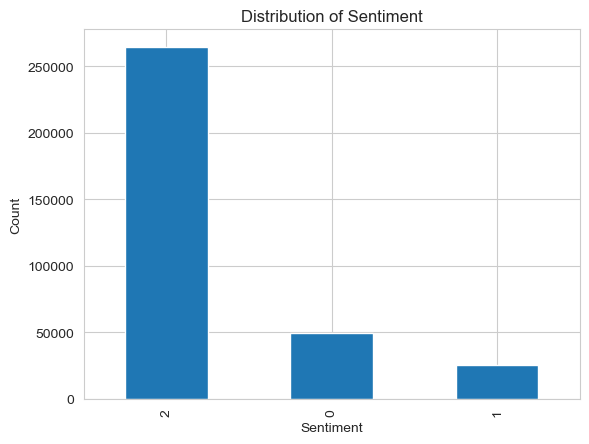

In [19]:
# Get the counts of each sentiment value
sentiment_counts = review_df['Sentiment'].value_counts()

# Create a new figure and axis
fig1, ax1 = plt.subplots()

# Plot the bar graph
sentiment_counts.plot(kind='bar', ax=ax1)

# Set labels and title
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Sentiment')

# Show the plot
plt.show()

Remove Unnecessary Columns: Since the goal is NLP-based analysis, I can safely remove columns like Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, and Time as they are not directly related to the text content analysis.

In [20]:
columns_to_drop = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']

# Drop the columns
review_df = review_df.drop(columns=columns_to_drop)

# Display the updated DataFrame
review_df.head()

,Score,Summary,Text,Sentiment
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,2
4,5,Great taffy,Great taffy at a great price. There was a wid...,2
5,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,2


##### Text Processing

In [21]:
# Define functions for text preprocessing
def remove_special_characters(text):
    pattern = r'[^\w\s]'
    clean_text = re.sub(pattern, '', text)
    return clean_text

def convert_lower_case(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(tokens)
    
# Define a function to remove HTML tags
def remove_html_tags(text):
    # Use BeautifulSoup to parse the HTML content and get the text
    soup = BeautifulSoup(text, "html.parser")
    # Return the text without HTML tags
    return soup.get_text()

def lemmatization(texts):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        texts_out.append(' '.join([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]))
    return texts_out

In [22]:
# Load pre-trained GloVe embeddings (assuming GloVe file is available)
embeddings_index = {}
embedding_dim = 200
glove_file = 'glove.6B.200d.txt'

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [23]:
# Preprocess text data
review_df['Summary'] = review_df['Summary'].apply(remove_special_characters)
review_df['Summary'] = review_df['Summary'].apply(convert_lower_case)
review_df['Text'] = review_df['Text'].apply(remove_special_characters)
review_df['Text'] = review_df['Text'].apply(convert_lower_case)
review_df['Summary'] = review_df['Summary'].apply(remove_stopwords)
review_df['Text'] = review_df['Text'].apply(remove_stopwords)
review_df['Text'] = review_df['Text'].apply(remove_html_tags)
review_df['Text_Summary'] = review_df['Summary'] + ' ' + review_df['Text']
review_df['Text_Summary'] = lemmatization(review_df['Text_Summary'])

In [24]:
from sklearn.preprocessing import LabelEncoder
# Encode the target variable 'Sentiment'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(review_df['Sentiment'])

In [25]:
# Text tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_df['Text_Summary'])
X_tokenized = tokenizer.texts_to_sequences(review_df['Text_Summary'])

# Pad sequences
max_sequence_length = 100
X_padded = pad_sequences(X_tokenized, maxlen=max_sequence_length)

# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
# Define and train the model
subset_size = 80000 
X_sub = X_padded[:subset_size] 
y_sub = y[:subset_size] 

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer

In [28]:
# Get the number of features in the dataset
num_features = X_sub.shape[1]

# Apply Incremental PCA for dimensionality reduction
n_components = min(num_features, 100)  # Set n_components to be less than or equal to the number of features
batch_size = 512

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
X_ipca = ipca.fit_transform(X_sub)

# Split into training and testing sets
X_train_ipca, X_test_ipca, y_train_ipca, y_test_ipca = train_test_split(X_ipca, y_sub, test_size=0.2, random_state=42)

# Establish baseline model on resampled data
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_ipca, y_train_ipca)  
baseline_predictions = baseline_model.predict(X_test_ipca)

# Evaluate baseline accuracy on resampled data
baseline_accuracy = accuracy_score(y_test_ipca, baseline_predictions)
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.77325


In [29]:
x_df = review_df['Text_Summary']
y_df = review_df ['Sentiment']

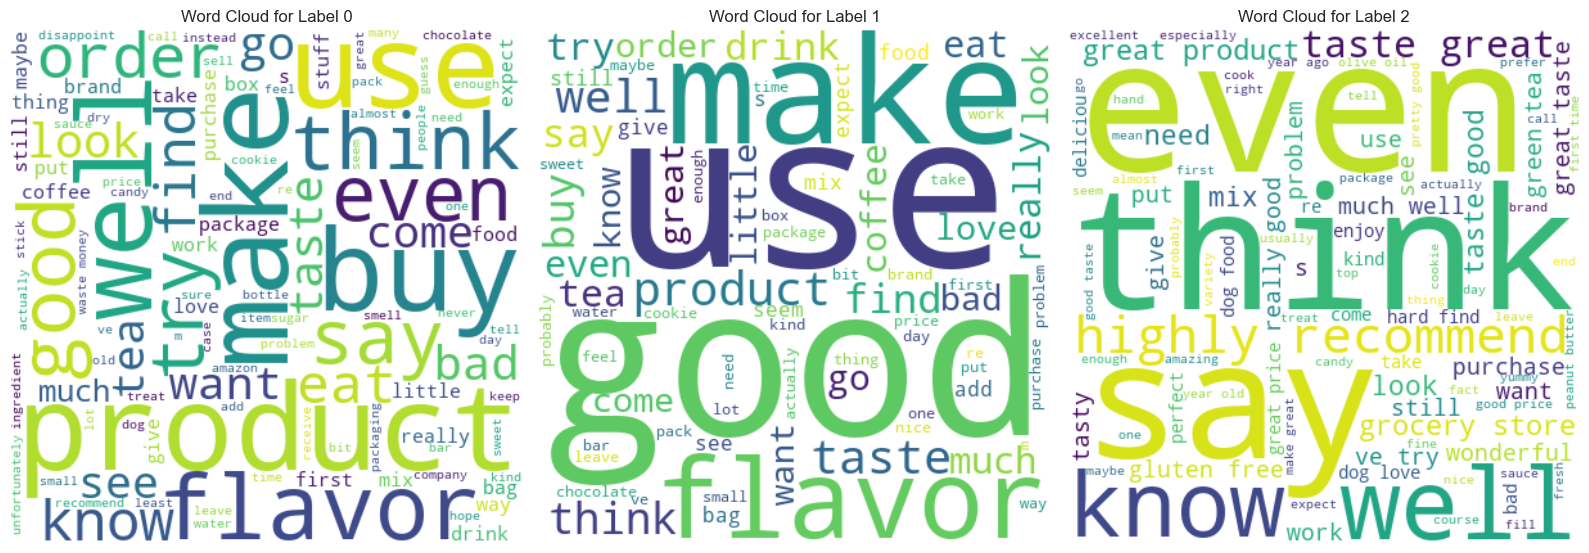

In [30]:
unique_labels = set(y_df)

# Define a function to generate word cloud for each label
def generate_wordcloud_for_label(label, x_df, y_df, ax):
    filtered_text = x_df[y_df == label]
    
    # Concatenate text data
    text_data = ' '.join(filtered_text)
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=400, background_color='white', min_font_size=10).generate(text_data)
    
    # Plot word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for Label {label}')
    ax.axis("off")

# Create subplots for each label
fig, axes = plt.subplots(1, len(unique_labels), figsize=(16, 8))

# Iterate through each label and generate word cloud
for i, label in enumerate(unique_labels):
    generate_wordcloud_for_label(label, x_df, y_df, axes[i])

plt.tight_layout()
plt.show()

### Naive Bayes

In [31]:
# Split the preprocessed and resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

# Initialize Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

In [32]:
# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_classifier.predict(X_test)

In [33]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.35      0.21      2367
           1       0.11      0.25      0.15      1261
           2       0.79      0.49      0.60     12372

    accuracy                           0.45     16000
   macro avg       0.35      0.36      0.32     16000
weighted avg       0.64      0.45      0.51     16000



In [34]:
# Calculate accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Model Accuracy:", accuracy)

Naive Bayes Model Accuracy: 0.4494375


In [35]:
# Calculate F1 score for each class separately
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 Score for each class:", f1_scores)

# Calculate overall F1 score (average of F1 scores for all classes)
overall_f1_score = np.mean(f1_scores)
print("Overall F1 Score:", overall_f1_score)

# Calculate precision for each class separately
precisions = precision_score(y_test, y_pred, average=None)
print("Precision for each class:", precisions)

# Calculate overall precision (average of precision for all classes)
overall_precision = np.mean(precisions)
print("Overall Precision:", overall_precision)

# Calculate recall for each class separately
recalls = recall_score(y_test, y_pred, average=None)
print("Recall for each class:", recalls)

# Calculate overall recall (average of recall for all classes)
overall_recall = np.mean(recalls)
print("Overall Recall:", overall_recall)

F1 Score for each class: [0.21203585 0.15373459 0.60290231]
Overall F1 Score: 0.3228909168789163
Precision for each class: [0.15212199 0.11057024 0.7870069 ]
Overall Precision: 0.3498997093771627
Recall for each class: [0.34980989 0.25218081 0.4886033 ]
Overall Recall: 0.36353133086085165


Confusion Matrix:
[[ 828  432 1107]
 [ 414  318  529]
 [4201 2126 6045]]


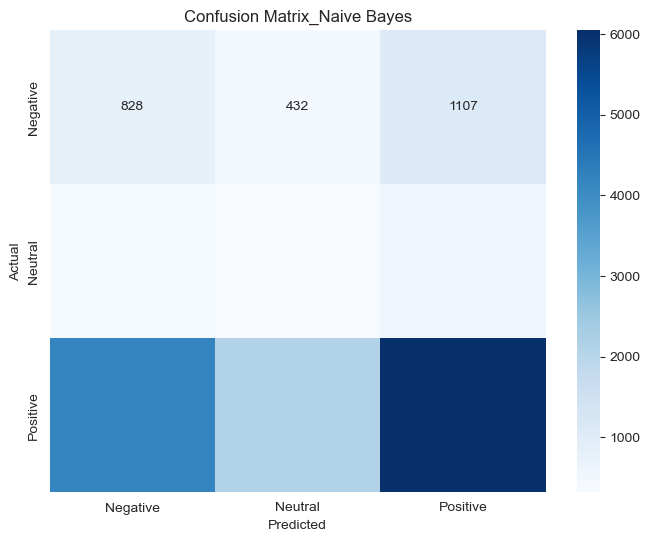

In [36]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing confusion matrix as a heatmap
fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix_Naive Bayes')

# Show the plot
plt.show()

In [37]:
# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
# Get predicted probabilities for each class
y_prob_all_np = nb_classifier.predict_proba(X_test)
# Calculate the AUC score
auc_score = roc_auc_score(y_test_binarized, y_prob_all_np, multi_class='ovr')

# Print the AUC score
print("AUC Score_Naive Bayes:", auc_score)

AUC Score_Naive Bayes: 0.5163205312459708


In [38]:
# Initialize lists to store fpr, tpr, and roc_auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC AUC score for each class
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_all_np[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_prob_all_np[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob_all_np.ravel())
roc_auc["micro"] = roc_auc_score(y_test_binarized.ravel(), y_prob_all_np.ravel())

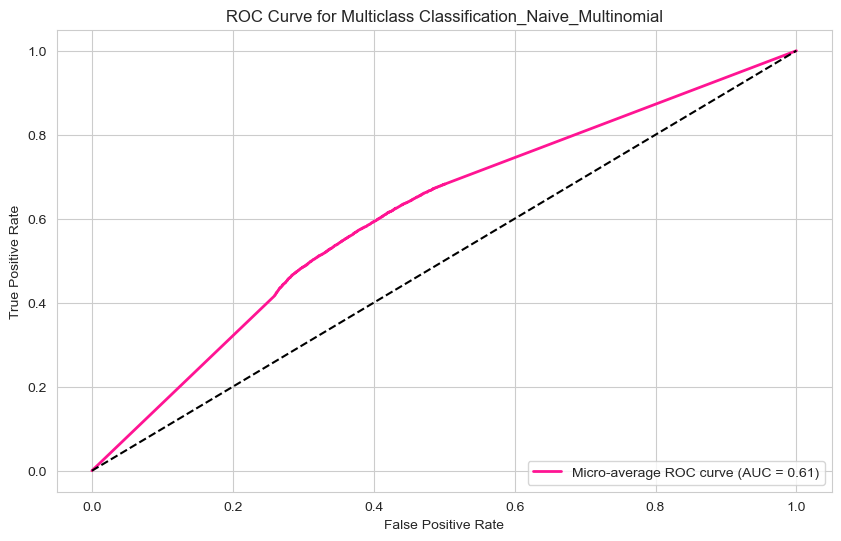

In [39]:
# Plot ROC curve
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc["micro"]), color='deeppink', linewidth=2)
ax3.plot([0, 1], [0, 1], color='black', linestyle='--')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve for Multiclass Classification_Naive_Multinomial')
ax3.legend(loc="lower right")
plt.show()

##### Optimization with TfidfVectorizer

In [40]:
# Convert the training and testing data to a list of strings
X_train_texts = [" ".join(map(str, doc)) for doc in X_train]
X_test_texts = [" ".join(map(str, doc)) for doc in X_test]

In [41]:
# Define the pipeline with TfidfVectorizer and Multinomial Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB(alpha=0.1))
])

# Train the model using the full training data
pipeline.fit(X_train_texts, y_train)

# Predict the labels for the test set
y_pred = pipeline.predict(X_test_texts)

In [42]:
# Evaluate the model
accuracy = pipeline.score(X_test_texts, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8045625


In [43]:
# Get predicted labels from the model
y_pred = pipeline.predict(X_test_texts)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.23      0.36      2367
           1       0.48      0.01      0.02      1261
           2       0.80      0.99      0.89     12372

    accuracy                           0.80     16000
   macro avg       0.70      0.41      0.42     16000
weighted avg       0.78      0.80      0.74     16000



In [44]:
# Calculate F1 score for each class separately
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 Score for each class:", f1_scores)

# Calculate overall F1 score (average of F1 scores for all classes)
overall_f1_score = np.mean(f1_scores)
print("Overall F1 Score:", overall_f1_score)

# Calculate precision for each class separately
precisions = precision_score(y_test, y_pred, average=None)
print("Precision for each class:", precisions)

# Calculate overall precision (average of precision for all classes)
overall_precision = np.mean(precisions)
print("Overall Precision:", overall_precision)

# Calculate recall for each class separately
recalls = recall_score(y_test, y_pred, average=None)
print("Recall for each class:", recalls)

# Calculate overall recall (average of recall for all classes)
overall_recall = np.mean(recalls)
print("Overall Recall:", overall_recall)

F1 Score for each class: [0.36465177 0.01713396 0.88949118]
Overall F1 Score: 0.42375897093018705
Precision for each class: [0.81979321 0.47826087 0.80437908]
Overall Precision: 0.7008110532833718
Recall for each class: [0.23447402 0.00872324 0.9947462 ]
Overall Recall: 0.4126478181235318


Confusion Matrix:
[[  555     6  1806]
 [   63    11  1187]
 [   59     6 12307]]


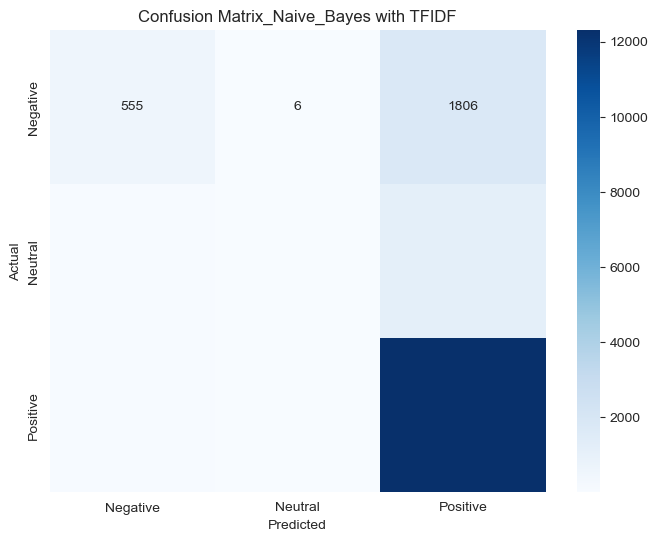

In [45]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing confusion matrix as a heatmap
fig4, ax4 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax4)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title('Confusion Matrix_Naive_Bayes with TFIDF')

# Show the plot
plt.show()

In [46]:
# Get predicted probabilities for each class
y_prob_all_np = pipeline.predict_proba(X_test_texts)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the AUC score
auc_score = roc_auc_score(y_test_binarized, y_prob_all_np, multi_class='ovr')

# Print the AUC score
print("AUC Score:", auc_score)

AUC Score: 0.8524302711872478


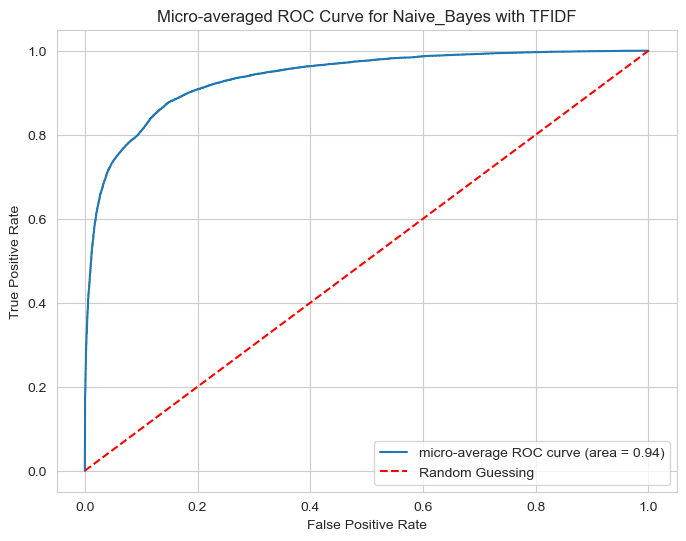

In [47]:
# Compute micro-averaged ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_prob_all_np.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
fig5, ax5 = plt.subplots(figsize=(8, 6))
ax5.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (area = %0.2f)' % roc_auc_micro)

# Plot random guessing line
ax5.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Set plot labels and legend
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('Micro-averaged ROC Curve for Naive_Bayes with TFIDF')
ax5.legend(loc="lower right")

# Show the plot
plt.show()

##### Including N-gram (1,2)

In [48]:
# Define the pipeline with TfidfVectorizer and Multinomial Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('nb', MultinomialNB(alpha=0.1))
])

# Train the model using the full training data
pipeline.fit(X_train_texts, y_train)

# Predict the labels for the test set
y_pred = pipeline.predict(X_test_texts)

In [49]:
# Evaluate the model
accuracy = pipeline.score(X_test_texts, y_test)
print("Accuracy_TFIDF_N-gram:", accuracy)

Accuracy_TFIDF_N-gram: 0.7905625


In [50]:
# Calculate F1 score for each class separately
f1_scores = f1_score(y_test, y_pred, average=None)
print("F1 Score for each class:", f1_scores)

# Calculate overall F1 score (average of F1 scores for all classes)
overall_f1_score = np.mean(f1_scores)
print("Overall F1 Score:", overall_f1_score)

# Calculate precision for each class separately
precisions = precision_score(y_test, y_pred, average=None)
print("Precision for each class:", precisions)

# Calculate overall precision (average of precision for all classes)
overall_precision = np.mean(precisions)
print("Overall Precision:", overall_precision)

# Calculate recall for each class separately
recalls = recall_score(y_test, y_pred, average=None)
print("Recall for each class:", recalls)

# Calculate overall recall (average of recall for all classes)
overall_recall = np.mean(recalls)
print("Overall Recall:", overall_recall)

F1 Score for each class: [0.21303538 0.00945626 0.88119518]
Overall F1 Score: 0.3678956086246976
Precision for each class: [0.89937107 0.75       0.78837565]
Overall Precision: 0.8125822410438683
Recall for each class: [0.12082805 0.00475813 0.99878758]
Overall Recall: 0.3747912552418385


In [51]:
# Get predicted probabilities for each class
y_prob_all_np = pipeline.predict_proba(X_test_texts)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the AUC score
auc_score = roc_auc_score(y_test_binarized, y_prob_all_np, multi_class='ovr')

# Print the AUC score
print("AUC Score:", auc_score)

AUC Score: 0.821651467194441


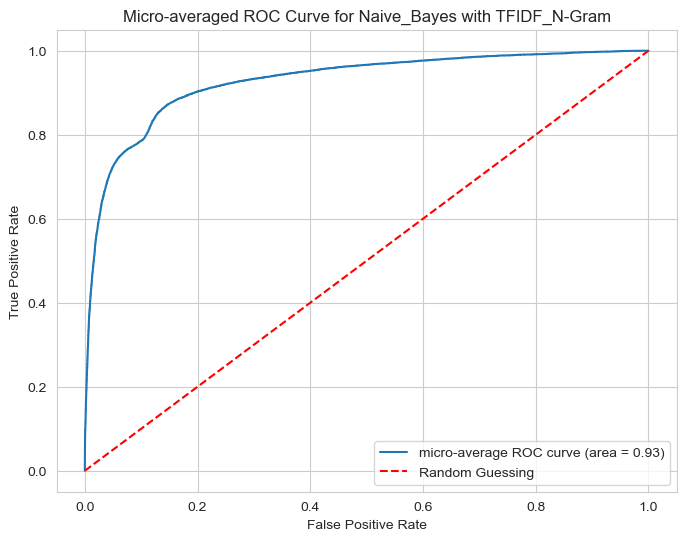

In [52]:
# Compute micro-averaged ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_prob_all_np.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
fig6, ax6 = plt.subplots(figsize=(8, 6))
ax6.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (area = %0.2f)' % roc_auc_micro)

# Plot random guessing line
ax6.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Set plot labels and legend
ax6.set_xlabel('False Positive Rate')
ax6.set_ylabel('True Positive Rate')
ax6.set_title('Micro-averaged ROC Curve for Naive_Bayes with TFIDF_N-Gram')
ax6.legend(loc="lower right")

# Show the plot
plt.show()

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
# Define and train the model
subset_size = 80000 
X_sub = X_padded[:subset_size] 
y_sub = y[:subset_size] 

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

In [55]:
# Define the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# Predict on the test data
y_pred = model_rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7741875


In [57]:
# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

Precision: 0.8078752484568071
Recall: 0.7741875
F1-score: 0.6768266077657691


In [58]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[   15     0  2352]
 [    0     2  1259]
 [    2     0 12370]]


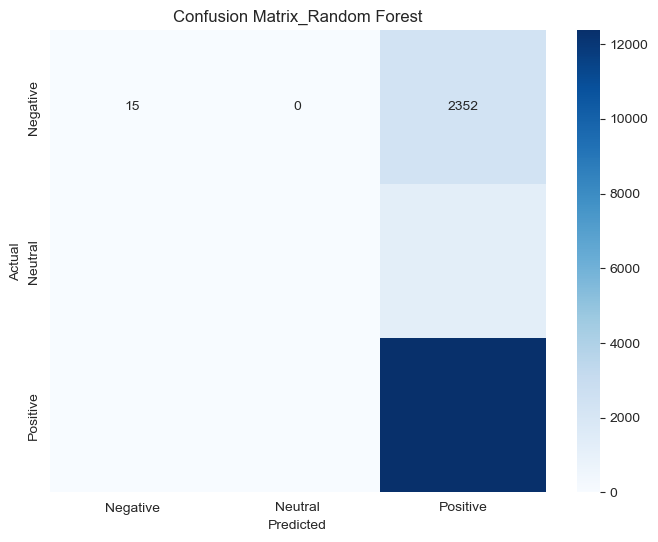

In [59]:
# Visualizing confusion matrix as a heatmap
fig7, ax7 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax7)
ax7.set_xlabel('Predicted')
ax7.set_ylabel('Actual')
ax7.set_title('Confusion Matrix_Random Forest')

# Show the plot
plt.show()

##### Random Forest Model Oversampling

In [61]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [62]:
# Train the model on the resampled training data
model_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [63]:
# Predict on the test data
y_pred = model_rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6603125


In [64]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 477  142 1748]
 [ 196  104  961]
 [1694  694 9984]]


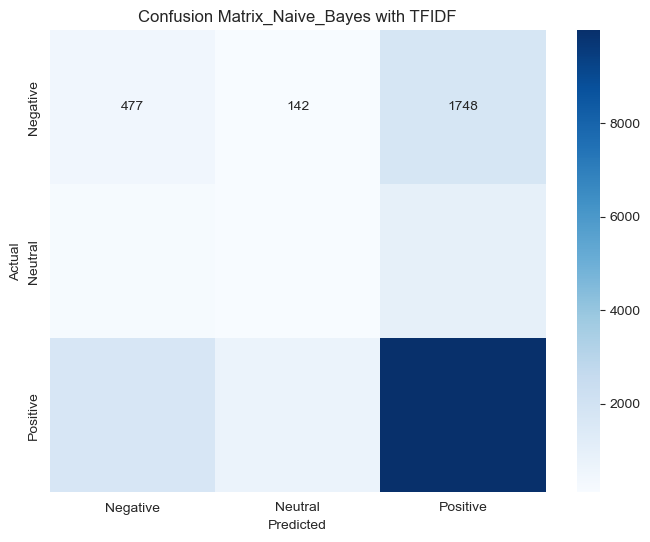

In [65]:
# Visualizing confusion matrix as a heatmap
fig8, ax8 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax8)
ax8.set_xlabel('Predicted')
ax8.set_ylabel('Actual')
ax8.set_title('Confusion Matrix_Naive_Bayes with TFIDF')

# Show the plot
plt.show()

##### Random Forest with SMOTE and Randomized Search

In [99]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [100]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution with reduced ranges
param_dist = {
    'n_estimators': randint(100, 200), 
    'max_depth': [10, 20],             
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'bootstrap': [True]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

In [101]:
# Train the model on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [102]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.695


In [103]:
# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

Precision: 0.6686411573360727
Recall: 0.695
F1-score: 0.6806947269476162


In [104]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  58   16  208]
 [  26    9  121]
 [ 132  107 1323]]


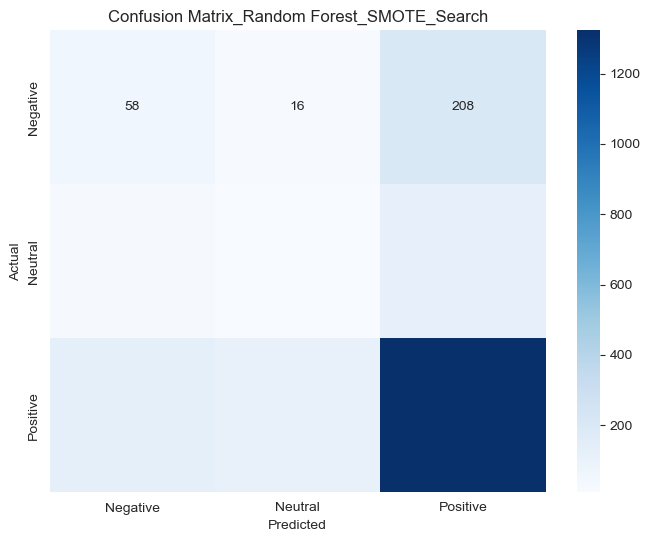

In [105]:
# Visualizing confusion matrix as a heatmap
fig9, ax9 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax9)
ax9.set_xlabel('Predicted')
ax9.set_ylabel('Actual')
ax9.set_title('Confusion Matrix_Random Forest_SMOTE_Search')

# Show the plot
plt.show()

In [106]:
# Get predicted probabilities for each class
y_prob_all_np = best_model.predict_proba(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the AUC score
auc_score = roc_auc_score(y_test_binarized, y_prob_all_np, multi_class='ovr')

# Print the AUC score
print("AUC Score:", auc_score)

AUC Score: 0.5875455507895653


##### Random Forest with Randomised Search

In [107]:
# Define the parameter distribution with reduced ranges
param_dist = {
    'n_estimators': randint(100, 200), 
    'max_depth': [10, 20],             
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'bootstrap': [True]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=5, 
                                   random_state=42)

In [108]:
# Train the model on the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [109]:
# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.781


In [110]:
# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

Precision: 0.609961
Recall: 0.781
F1-score: 0.6849646266142616


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[   0    0  282]
 [   0    0  156]
 [   0    0 1562]]


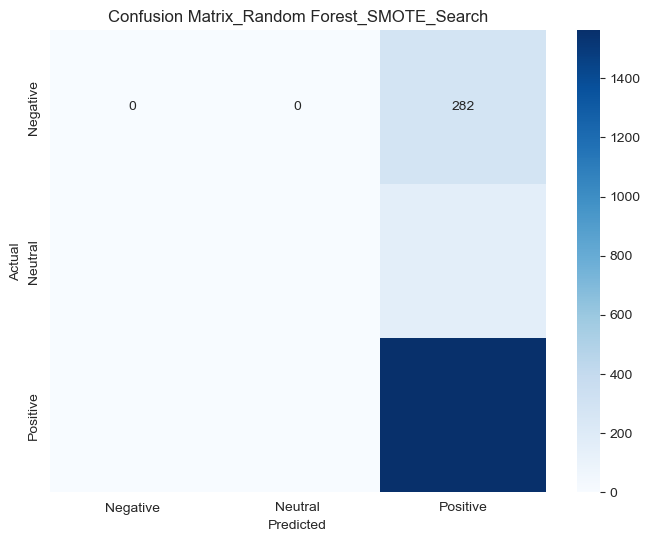

In [112]:
# Visualizing confusion matrix as a heatmap
fig9_1, ax9_1 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax9_1)
ax9_1.set_xlabel('Predicted')
ax9_1.set_ylabel('Actual')
ax9_1.set_title('Confusion Matrix_Random Forest_SMOTE_Search')

# Show the plot
plt.show()

### DEEP LEARNING

#### RNN

In [114]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import keras

In [115]:
# Define and train the model
subset_size = 10000 
X_sub = X_padded[:subset_size] 
y_sub = y[:subset_size] 

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

In [116]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# LSTM layer
lstm_layer = LSTM(units=64, return_sequences=False)(embedding_layer)

# Dense layer for classification
output = Dense(3, activation='softmax')(lstm_layer)

# Build the model
model1 = Model(inputs=input_layer, outputs=output)

# Compile the model
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          67,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,711,435 (120.97 MB)

 Trainable params: 68,035 (265.76 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [117]:
# Train the model
history1 = model1.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7187 - loss: 0.7207 - val_accuracy: 0.7980 - val_loss: 0.5402
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7997 - loss: 0.5354 - val_accuracy: 0.8195 - val_loss: 0.4971
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8253 - loss: 0.4787 - val_accuracy: 0.8275 - val_loss: 0.4794
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8341 - loss: 0.4445 - val_accuracy: 0.8315 - val_loss: 0.4719
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8433 - loss: 0.4233 - val_accuracy: 0.8270 - val_loss: 0.4652
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8513 - loss: 0.4059 - val_accuracy: 0.8245 - val_loss: 0.4718
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8628 - loss: 0.3711 - val_accuracy: 0.8235 - val_loss: 0.4771
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8745 - loss: 0.3408 - val_accu

In [118]:
# Convert history to a DataFrame
history1_df = pd.DataFrame(history1.history)
history1_df

,accuracy,loss,val_accuracy,val_loss
0,0.771000,0.639208,0.7980,0.540200
1,0.808000,0.526039,0.8195,0.497117
2,0.823000,0.485296,0.8275,0.479385
3,0.832500,0.453888,0.8315,0.471931
4,0.840250,0.429320,0.8270,0.465184
5,0.851125,0.400347,0.8245,0.471815
6,0.859875,0.380053,0.8235,0.477117
7,0.871625,0.342504,0.8335,0.483793
8,0.882500,0.316929,0.8265,0.491135
9,0.896750,0.281520,0.8235,0.514896


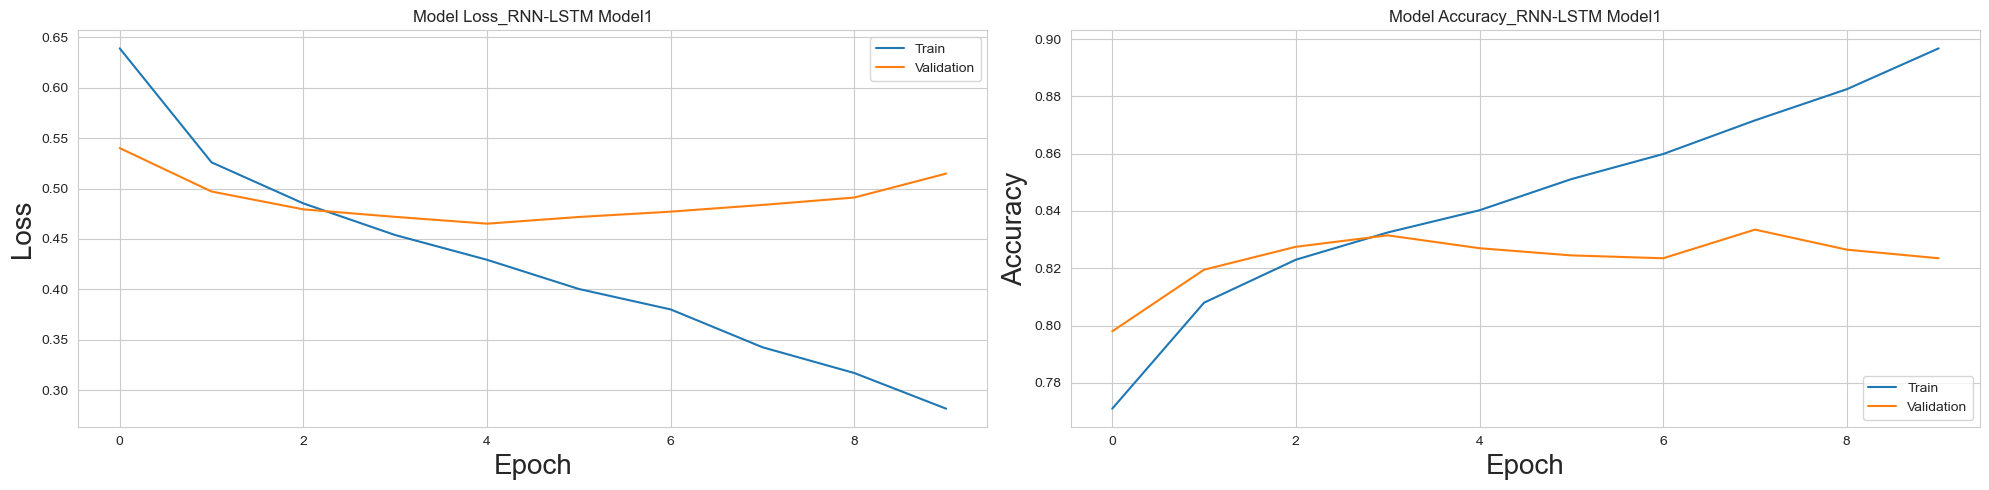

In [119]:
training_loss = history1_df['loss']
val_loss = history1_df['val_loss']
training_accuracy = history1_df['accuracy']
val_accuracy = history1_df['val_accuracy']

# Plot the loss
fig10, ax10 = plt.subplots(1, 2, figsize=(20, 5))
ax10[0].plot(training_loss)
ax10[0].plot(val_loss)
ax10[0].set_xlabel('Epoch', fontsize=20)
ax10[0].set_ylabel('Loss', fontsize=20)
ax10[0].set_title('Model Loss_RNN-LSTM Model1')
ax10[0].legend(['Train', 'Validation'], loc='upper right')

# Plot the accuracy
ax10[1].plot(training_accuracy)
ax10[1].plot(val_accuracy)
ax10[1].set_xlabel('Epoch', fontsize=20)
ax10[1].set_ylabel('Accuracy', fontsize=20)
ax10[1].set_title('Model Accuracy_RNN-LSTM Model1')
ax10[1].legend(['Train', 'Validation'], loc='lower right') 

plt.tight_layout()
plt.show()

In [120]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8375 - loss: 0.4874
Test Loss: 0.5148960947990417
Test Accuracy: 0.8234999775886536


In [121]:
# Evaluate the model
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precision: 0.7987440437471535
Recall: 0.8235
F1-score: 0.8087747592107958


In [122]:
# Predict labels for test data
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Simple RNN-LSTM Confusion Matrix:")
print(conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Simple RNN-LSTM Confusion Matrix:
[[ 163   20   99]
 [  39   23   94]
 [  63   38 1461]]


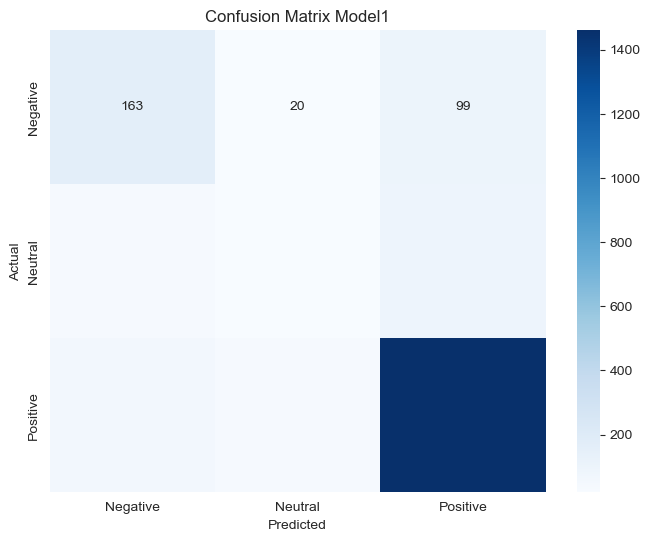

In [123]:
# Visualizing confusion matrix as a heatmap
fig11, ax11 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax11)
ax11.set_xlabel('Predicted')
ax11.set_ylabel('Actual')
ax11.set_title('Confusion Matrix Model1')

# Show the plot
plt.show()

In [124]:
# Get predicted probabilities
y_pred_probs = model1.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC Score:", auc_score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AUC Score: 0.8531390234114214


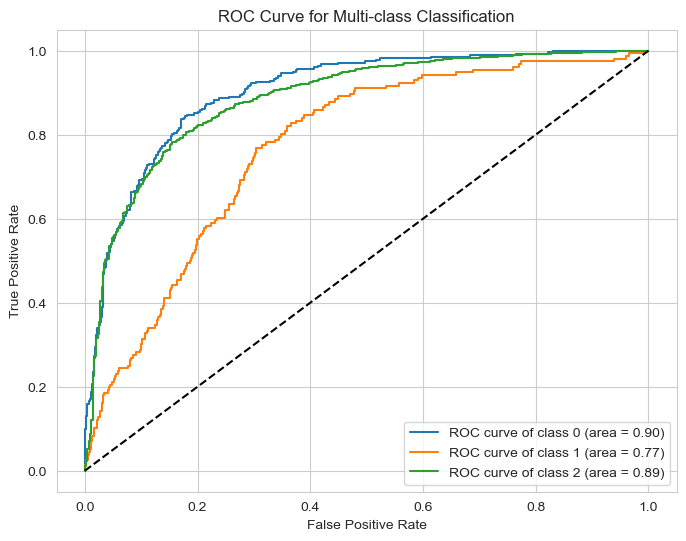

In [131]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curve for each class
fig12, ax12 = plt.subplots(figsize=(8, 6))

for i in range(n_classes):
    ax12.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:0.2f})'.format(i, roc_auc[i]))

ax12.plot([0, 1], [0, 1], 'k--')
ax12.set_xlabel('False Positive Rate')
ax12.set_ylabel('True Positive Rate')
ax12.set_title('ROC Curve for Multi-class Classification')
ax12.legend(loc="lower right")

plt.show()


##### Adding a Bidirectional LSTM layer with 64 units and an additional Dense layer with dropout

In [132]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))(embedding_layer)

# Additional LSTM layer
lstm_layer2 = LSTM(units=128, return_sequences=False)(lstm_layer)

# Dropout layer
dropout_layer = Dropout(0.5)(lstm_layer2)

# Dense layer for classification
output = Dense(3, activation='softmax')(dropout_layer)

# Build the model
model2 = Model(inputs=input_layer, outputs=output)

# Compile the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,911,051 (121.73 MB)

 Trainable params: 267,651 (1.02 MB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [133]:
# Train the model
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.7671 - loss: 0.6765 - val_accuracy: 0.8095 - val_loss: 0.5173
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.8164 - loss: 0.5124 - val_accuracy: 0.8245 - val_loss: 0.4773
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.8316 - loss: 0.4714 - val_accuracy: 0.8160 - val_loss: 0.4873
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.8271 - loss: 0.4720 - val_accuracy: 0.8185 - val_loss: 0.4870
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.8483 - loss: 0.4153 - val_accuracy: 0.8130 - val_loss: 0.4858
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.8550 - loss: 0.3989 - val_accuracy: 0.8340 - val_loss: 0.5170
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.8641 - loss: 0.3631 - val_accuracy: 0.8120 - val_loss: 0.5093
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.8838 - loss: 0

In [134]:
history2_df = pd.DataFrame(history2.history)
history2_df

,accuracy,loss,val_accuracy,val_loss
0,0.784500,0.614108,0.8095,0.517307
1,0.813000,0.523109,0.8245,0.477268
2,0.827125,0.482055,0.8160,0.487278
3,0.832750,0.461097,0.8185,0.487009
4,0.848125,0.418086,0.8130,0.485841
5,0.856000,0.395391,0.8340,0.516986
6,0.866625,0.353082,0.8120,0.509273
7,0.881000,0.317596,0.8020,0.521279
8,0.892625,0.273678,0.8160,0.561237
9,0.913250,0.234539,0.7750,0.609365


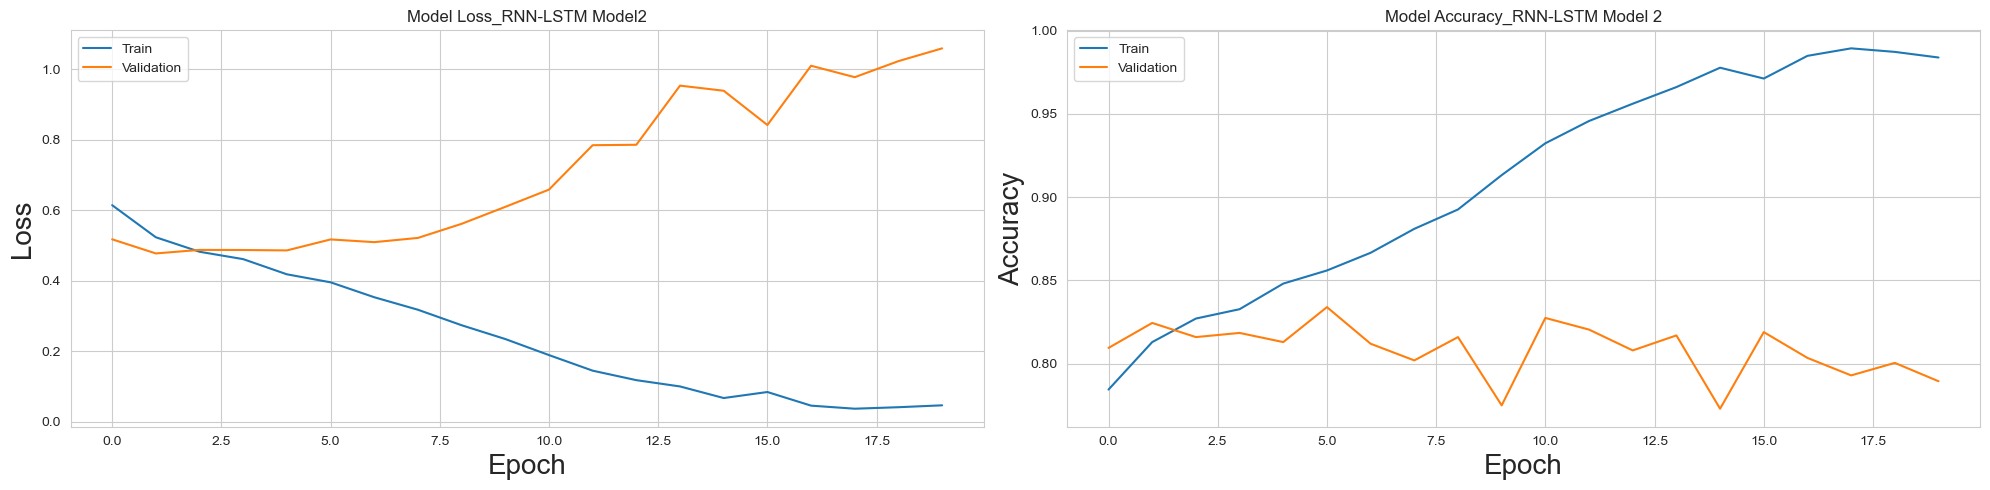

In [135]:
training_loss = history2_df['loss']
val_loss = history2_df['val_loss']
training_accuracy = history2_df['accuracy']
val_accuracy = history2_df['val_accuracy']

# Plot the loss
fig10, ax10 = plt.subplots(1, 2, figsize=(20, 5))
ax10[0].plot(training_loss)
ax10[0].plot(val_loss)
ax10[0].set_xlabel('Epoch', fontsize=20)
ax10[0].set_ylabel('Loss', fontsize=20)
ax10[0].set_title('Model Loss_RNN-LSTM Model2')
ax10[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the accuracy
ax10[1].plot(training_accuracy)
ax10[1].plot(val_accuracy)
ax10[1].set_xlabel('Epoch', fontsize=20)
ax10[1].set_ylabel('Accuracy', fontsize=20)
ax10[1].set_title('Model Accuracy_RNN-LSTM Model 2')
ax10[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [136]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7994 - loss: 1.0151
Test Loss: 1.0588157176971436
Test Accuracy: 0.7894999980926514


In [137]:
# Evaluate the model
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Precision: 0.7826736100853615
Recall: 0.7895
F1-score: 0.7859761152308614


In [138]:
# Predict labels for test data
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Simple RNN-LSTM Confusion Matrix Model2:")
print(conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Simple RNN-LSTM Confusion Matrix Model2:
[[ 156   33   93]
 [  38   27   91]
 [  92   74 1396]]


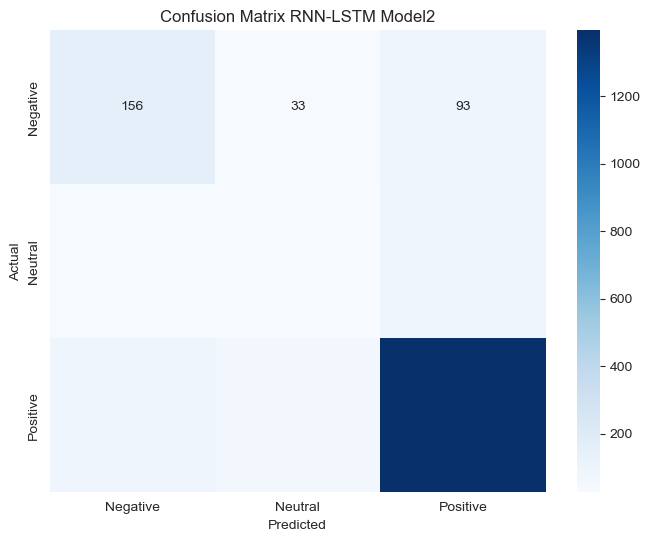

In [139]:
# Visualizing confusion matrix as a heatmap
fig13, ax13 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax13)
ax13.set_xlabel('Predicted')
ax13.set_ylabel('Actual')
ax13.set_title('Confusion Matrix RNN-LSTM Model2')

# Show the plot
plt.show()

In [140]:
# Get predicted probabilities
y_pred_probs = model2.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC Score Model2:", auc_score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
AUC Score Model2: 0.8177318263644601


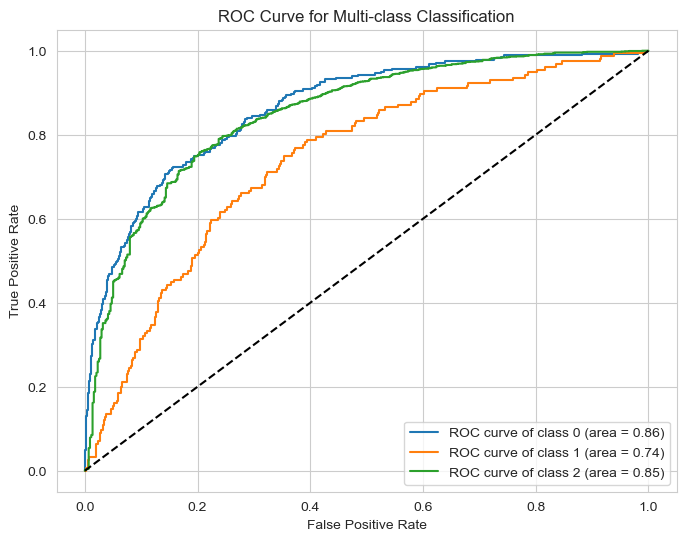

In [143]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curve for each class
fig14, ax14 = plt.subplots(figsize=(8, 6))

for i in range(n_classes):
    ax14.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:0.2f})'.format(i, roc_auc[i]))

ax14.plot([0, 1], [0, 1], 'k--')
ax14.set_xlabel('False Positive Rate')
ax14.set_ylabel('True Positive Rate')
ax14.set_title('ROC Curve for Multi-class Classification')
ax14.legend(loc="lower right")

plt.show()

##### More Optimization
Lower Learning Rate: Use the Adam optimizer with a lower learning rate.

New Dropout Rate: Change the dropout rate to 0.3.

Early Stopping: Implement early stopping to prevent overfitting and improve generalization.

Regularization: Apply L2 regularization to the LSTM layers.

In [144]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [145]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Bidirectional LSTM layer with L2 regularization
lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(embedding_layer)

# Additional LSTM layer with L2 regularization
lstm_layer2 = LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.001))(lstm_layer)

# Dropout layer with a dropout rate of 0.3
dropout_layer = Dropout(0.3)(lstm_layer2)

# Dense layer for classification
output = Dense(3, activation='softmax')(dropout_layer)

# Build the model
model3 = Model(inputs=input_layer, outputs=output)

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Specify learning_rate directly
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model3.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,177,803 (122.75 MB)

 Trainable params: 534,403 (2.04 MB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [146]:
# Train the model with early stopping
history3 = model3.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 333ms/step - accuracy: 0.7578 - loss: 1.2696 - val_accuracy: 0.8040 - val_loss: 0.6918
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - accuracy: 0.8028 - loss: 0.6987 - val_accuracy: 0.8160 - val_loss: 0.6226
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - accuracy: 0.8239 - loss: 0.6039 - val_accuracy: 0.8185 - val_loss: 0.5743
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.8213 - loss: 0.5652 - val_accuracy: 0.8140 - val_loss: 0.5597
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - accuracy: 0.8289 - loss: 0.5311 - val_accuracy: 0.8245 - val_loss: 0.5375
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.8352 - loss: 0.5210 - val_accuracy: 0.8275 - val_loss: 0.5417
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.8391 - loss: 0.4983 - val_accuracy: 0.8250 - val_loss: 0.5464
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.8283 - loss: 0

In [147]:
history3_df = pd.DataFrame(history3.history)
history3_df

,accuracy,loss,val_accuracy,val_loss
0,0.780375,1.007809,0.8040,0.691812
1,0.807625,0.671565,0.8160,0.622648
2,0.818000,0.605489,0.8185,0.574340
3,0.820875,0.568666,0.8140,0.559698
4,0.828625,0.538898,0.8245,0.537465
5,0.834250,0.524316,0.8275,0.541709
6,0.837625,0.503545,0.8250,0.546433
7,0.836625,0.502483,0.8315,0.520460
8,0.842750,0.482685,0.8290,0.528493
9,0.849500,0.471898,0.8290,0.532697


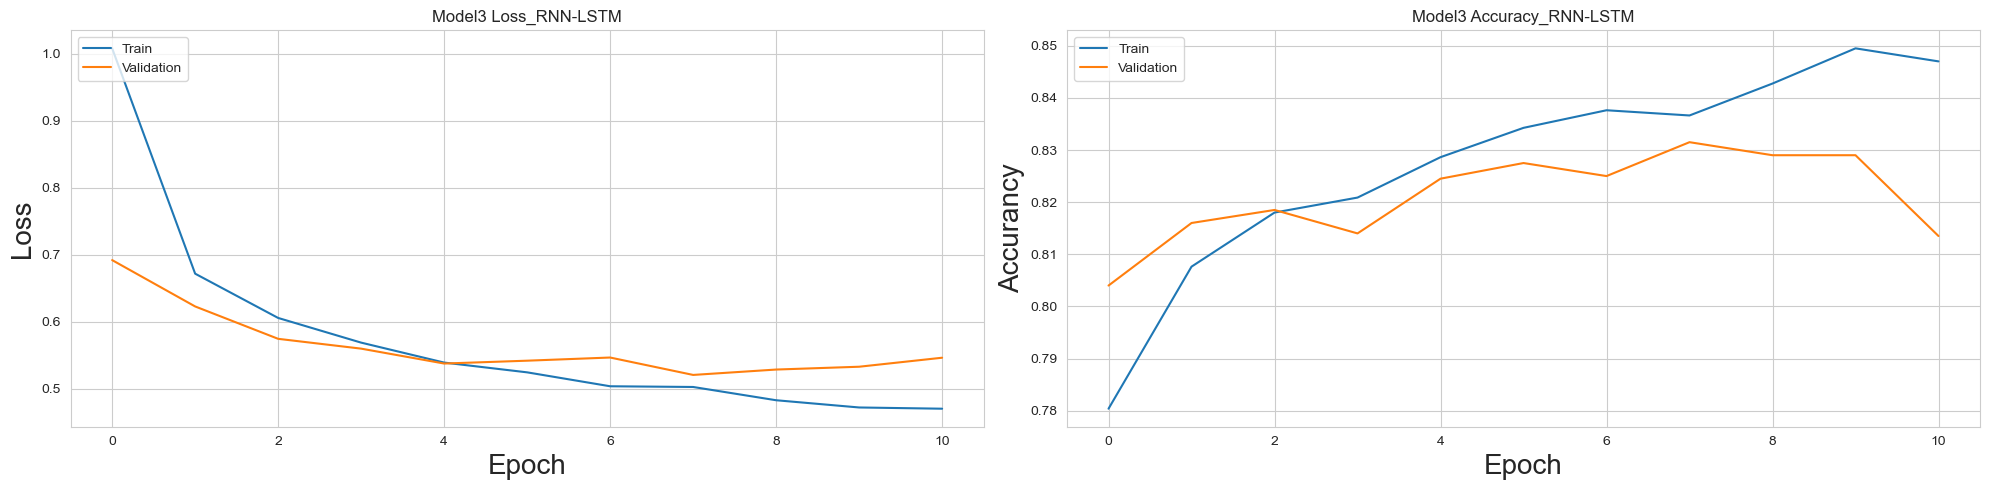

In [148]:
training_loss = history3_df['loss']
val_loss = history3_df['val_loss']
training_accurancy = history3_df['accuracy']
val_accurancy = history3_df ['val_accuracy']

#plot the loss
fig15, ax15 = plt.subplots(1,2, figsize =(20,5))
ax15[0].plot(training_loss)
ax15[0].plot(val_loss)
ax15[0].set_xlabel('Epoch', fontsize =20)
ax15[0].set_ylabel('Loss', fontsize =20)
ax15[0].set_title('Model3 Loss_RNN-LSTM')
ax15[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax15[1].plot(training_accurancy)
ax15[1].plot(val_accurancy )
ax15[1].set_xlabel('Epoch', fontsize =20)
ax15[1].set_ylabel('Accurancy', fontsize =20)
ax15[1].set_title('Model3 Accuracy_RNN-LSTM')
ax15[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [149]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy Model3:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8456 - loss: 0.5069
Test Loss: 0.5204605460166931
Test Accuracy Model3: 0.8314999938011169


In [150]:
# Evaluate the model
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Precision: 0.8001450691673865
Recall: 0.8315
F1-score: 0.7965119552187221


In [151]:
# Predict labels for test data
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Simple RNN-LSTM Confusion Matrix Model3:")
print(conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Simple RNN-LSTM Confusion Matrix Model3:
[[ 139    3  140]
 [  25    8  123]
 [  41    5 1516]]


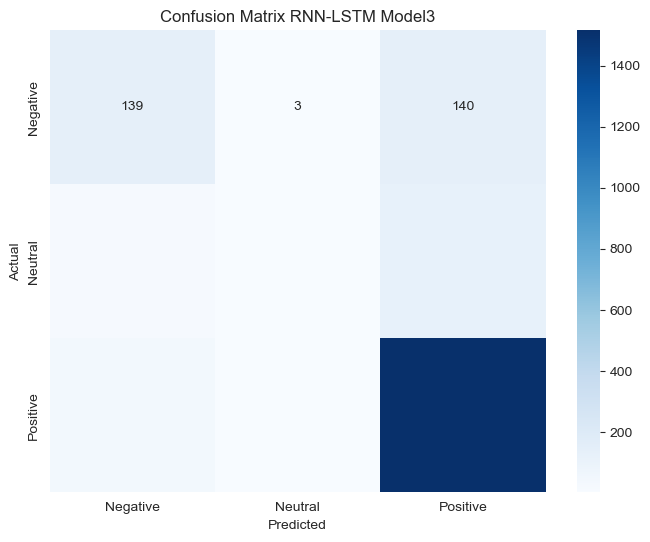

In [152]:
# Visualizing confusion matrix as a heatmap
fig16, ax16 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax16)
ax16.set_xlabel('Predicted')
ax16.set_ylabel('Actual')
ax16.set_title('Confusion Matrix RNN-LSTM Model3')

# Show the plot
plt.show()

In [153]:
# Get predicted probabilities
y_pred_probs = model3.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC Score Model 3:", auc_score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
AUC Score Model 3: 0.8509871951391504


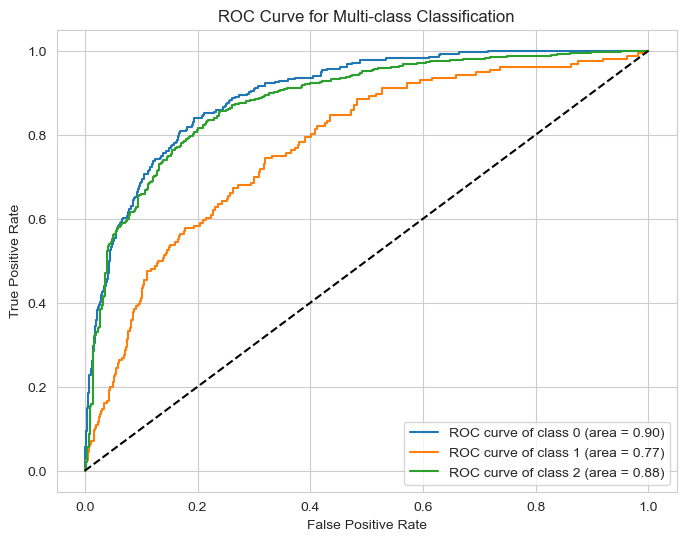

In [155]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curve for each class
fig17, ax17 = plt.subplots(figsize=(8, 6))

for i in range(n_classes):
    ax17.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:0.2f})'.format(i, roc_auc[i]))

ax17.plot([0, 1], [0, 1], 'k--')
ax17.set_xlabel('False Positive Rate')
ax17.set_ylabel('True Positive Rate')
ax17.set_title('ROC Curve for Multi-class Classification')
ax17.legend(loc="lower right")

plt.show()

##### Incorporation additional L2 regularizer

In [156]:
from keras.regularizers import l1_l2

In [157]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Bidirectional LSTM layer with L2 regularization
lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(embedding_layer)

# Additional LSTM layer with L2 regularization
lstm_layer2 = LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001))(lstm_layer)

# Additional LSTM layer with L1 and L2 regularization
lstm_layer3 = LSTM(units=128, return_sequences=False, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(lstm_layer2)

# Dropout layer with a dropout rate of 0.2
dropout_layer = Dropout(0.2)(lstm_layer3)

# Dense layer for classification
output = Dense(3, activation='softmax')(dropout_layer)

# Build the model
model4 = Model(inputs=input_layer, outputs=output)

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model4.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,309,387 (123.25 MB)

 Trainable params: 665,987 (2.54 MB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [158]:
# Train the model with early stopping
history4 = model4.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 530ms/step - accuracy: 0.7602 - loss: 4.8160 - val_accuracy: 0.7810 - val_loss: 3.9681
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - accuracy: 0.7810 - loss: 3.7457 - val_accuracy: 0.8050 - val_loss: 3.1066
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - accuracy: 0.8067 - loss: 2.9596 - val_accuracy: 0.8095 - val_loss: 2.4760
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 406ms/step - accuracy: 0.8206 - loss: 2.3465 - val_accuracy: 0.8180 - val_loss: 1.9841
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - accuracy: 0.8198 - loss: 1.8829 - val_accuracy: 0.8245 - val_loss: 1.5864
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.8262 - loss: 1.5035 - val_accuracy: 0.8200 - val_loss: 1.3076
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - accuracy: 0.8251 - loss: 1.2451 - val_accuracy: 0.8215 - val_loss: 1.1023
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 403ms/step - accuracy: 0.8213 - loss: 1

In [159]:
history4_df = pd.DataFrame(history4.history)
history4_df

,accuracy,loss,val_accuracy,val_loss
0,0.769250,4.521786,0.7810,3.968064
1,0.786500,3.535381,0.8050,3.106558
2,0.807250,2.804946,0.8095,2.475955
3,0.814750,2.232213,0.8180,1.984094
4,0.819750,1.785800,0.8245,1.586405
5,0.823625,1.442716,0.8200,1.307571
6,0.826375,1.191745,0.8215,1.102334
7,0.824125,1.039104,0.8215,0.985774
8,0.833125,0.949745,0.8250,0.943293
9,0.835625,0.887687,0.8210,0.889132


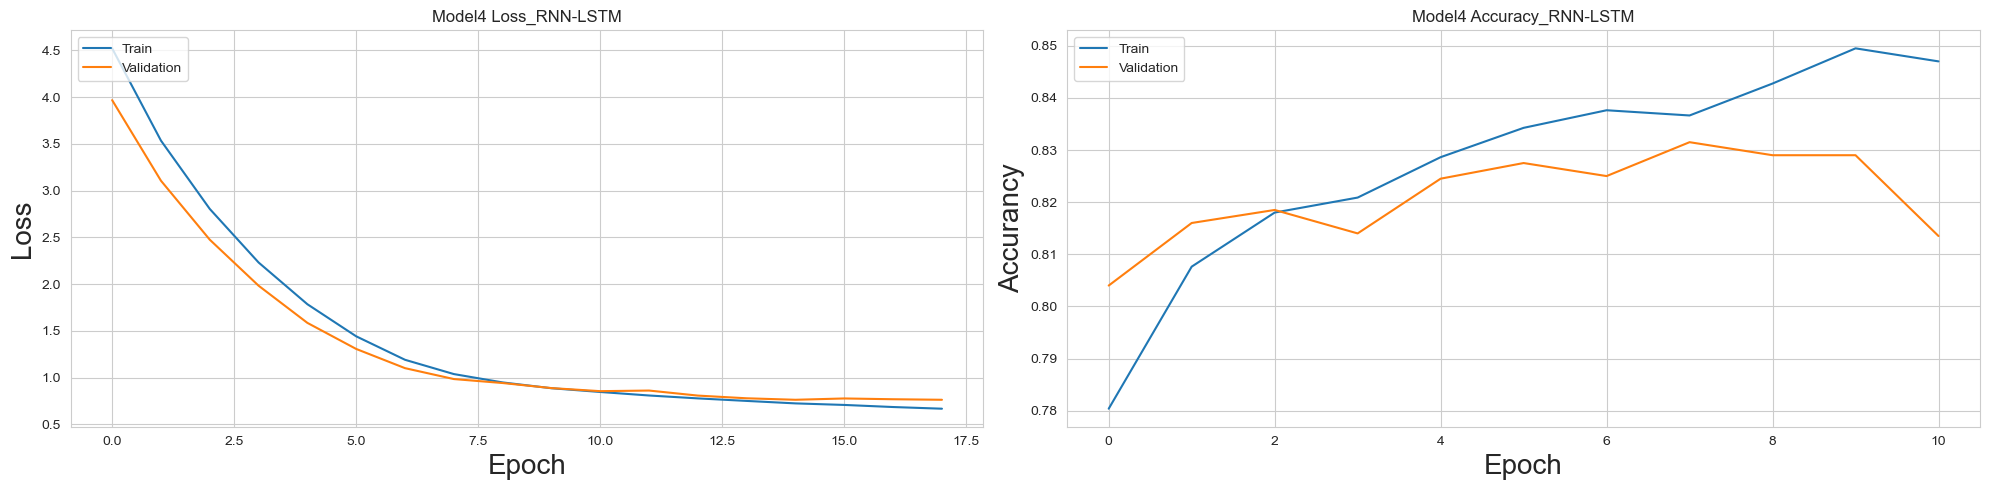

In [160]:
training_loss = history4_df['loss']
val_loss = history4_df['val_loss']
training_accuracy = history4_df['accuracy']
val_accuracy = history4_df ['val_accuracy']

#plot the loss
fig18, ax18 = plt.subplots(1,2, figsize =(20,5))
ax18[0].plot(training_loss)
ax18[0].plot(val_loss)
ax18[0].set_xlabel('Epoch', fontsize =20)
ax18[0].set_ylabel('Loss', fontsize =20)
ax18[0].set_title('Model4 Loss_RNN-LSTM')
ax18[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax18[1].plot(training_accurancy)
ax18[1].plot(val_accurancy )
ax18[1].set_xlabel('Epoch', fontsize =20)
ax18[1].set_ylabel('Accurancy', fontsize =20)
ax18[1].set_title('Model4 Accuracy_RNN-LSTM')
ax18[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [161]:
# Evaluate the model
loss, accuracy = model4.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy Model4:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8328 - loss: 0.7564
Test Loss: 0.7641829252243042
Test Accuracy Model4: 0.8274999856948853


In [162]:
# Evaluate the model
y_pred = model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step
Precision: 0.7814497496662217
Recall: 0.8275
F1-score: 0.7946339764039819


In [163]:
# Predict labels for test data
y_pred = model4.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Simple RNN-LSTM Confusion Matrix Model4:")
print(conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
Simple RNN-LSTM Confusion Matrix Model4:
[[ 166    4  112]
 [  41    2  113]
 [  73    2 1487]]


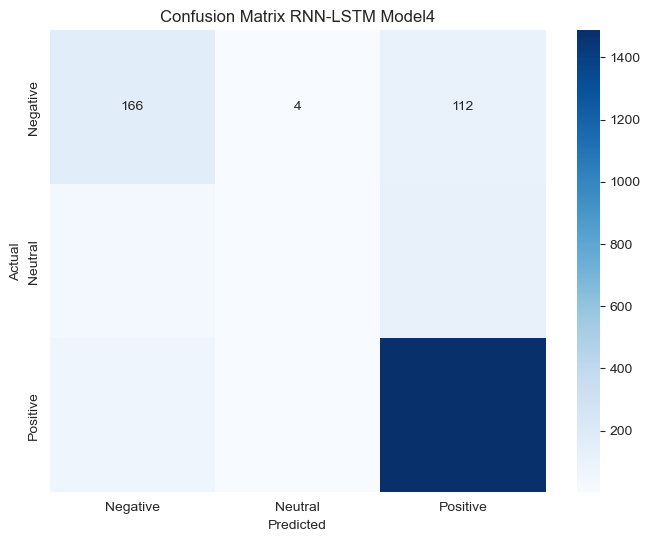

In [164]:
# Visualizing confusion matrix as a heatmap
fig19, ax19 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax19)
ax19.set_xlabel('Predicted')
ax19.set_ylabel('Actual')
ax19.set_title('Confusion Matrix RNN-LSTM Model4')

# Show the plot
plt.show()

In [165]:
# Get predicted probabilities
y_pred_probs = model4.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC Score Model 4:", auc_score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
AUC Score Model 4: 0.8566264467357293


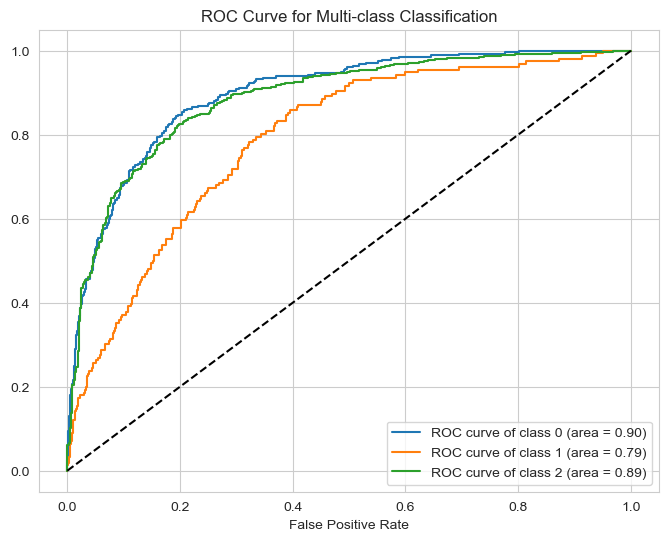

In [166]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curve for each class
fig20, ax20 = plt.subplots(figsize=(8, 6))

for i in range(n_classes):
    ax20.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {:0.2f})'.format(i, roc_auc[i]))

ax20.plot([0, 1], [0, 1], 'k--')
ax20.set_xlabel('False Positive Rate')
ax20.set_title('ROC Curve for Multi-class Classification')
ax20.legend(loc="lower right")

plt.show()

##### Adding a GRU layer to the model

In [167]:
from keras.layers import GRU

# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Bidirectional LSTM layer with L2 regularization
lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(embedding_layer)

# Replace the second LSTM layer with a GRU layer
gru_layer = GRU(units=128, return_sequences=False, kernel_regularizer=l2(0.001))(lstm_layer)

# Dropout layer with a dropout rate of 0.3
dropout_layer = Dropout(0.3)(gru_layer)

# Dense layer for classification
output = Dense(3, activation='softmax')(dropout_layer)

# Build the model
model_with_gru = Model(inputs=input_layer, outputs=output)

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Specify learning_rate directly
model_with_gru.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_with_gru.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,128,907 (122.56 MB)

 Trainable params: 485,507 (1.85 MB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [168]:
# Train the model with early stopping
history5 = model_with_gru.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 546ms/step - accuracy: 0.7752 - loss: 1.2339 - val_accuracy: 0.8180 - val_loss: 0.7076
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 562ms/step - accuracy: 0.8139 - loss: 0.6900 - val_accuracy: 0.8210 - val_loss: 0.6331
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 557ms/step - accuracy: 0.8327 - loss: 0.5895 - val_accuracy: 0.8210 - val_loss: 0.5813
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 569ms/step - accuracy: 0.8341 - loss: 0.5473 - val_accuracy: 0.8245 - val_loss: 0.5544
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 573ms/step - accuracy: 0.8432 - loss: 0.5157 - val_accuracy: 0.8325 - val_loss: 0.5475
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 574ms/step - accuracy: 0.8457 - loss: 0.4980 - val_accuracy: 0.8245 - val_loss: 0.5480
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.8403 - loss: 0.5067 - val_accuracy: 0.8145 - val_loss: 0.5576
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 557ms/step - accuracy: 0.8522 - loss: 0

In [169]:
history5_df = pd.DataFrame(history5.history)
history5_df

,accuracy,loss,val_accuracy,val_loss
0,0.784750,1.002490,0.8180,0.707623
1,0.813250,0.673451,0.8210,0.633097
2,0.821500,0.599925,0.8210,0.581336
3,0.829250,0.558329,0.8245,0.554398
4,0.832750,0.530755,0.8325,0.547511
5,0.839750,0.513258,0.8245,0.547961
6,0.842625,0.494459,0.8145,0.557555
7,0.843625,0.484976,0.8370,0.536546
8,0.846750,0.475881,0.8325,0.530172
9,0.851125,0.458966,0.8200,0.537010


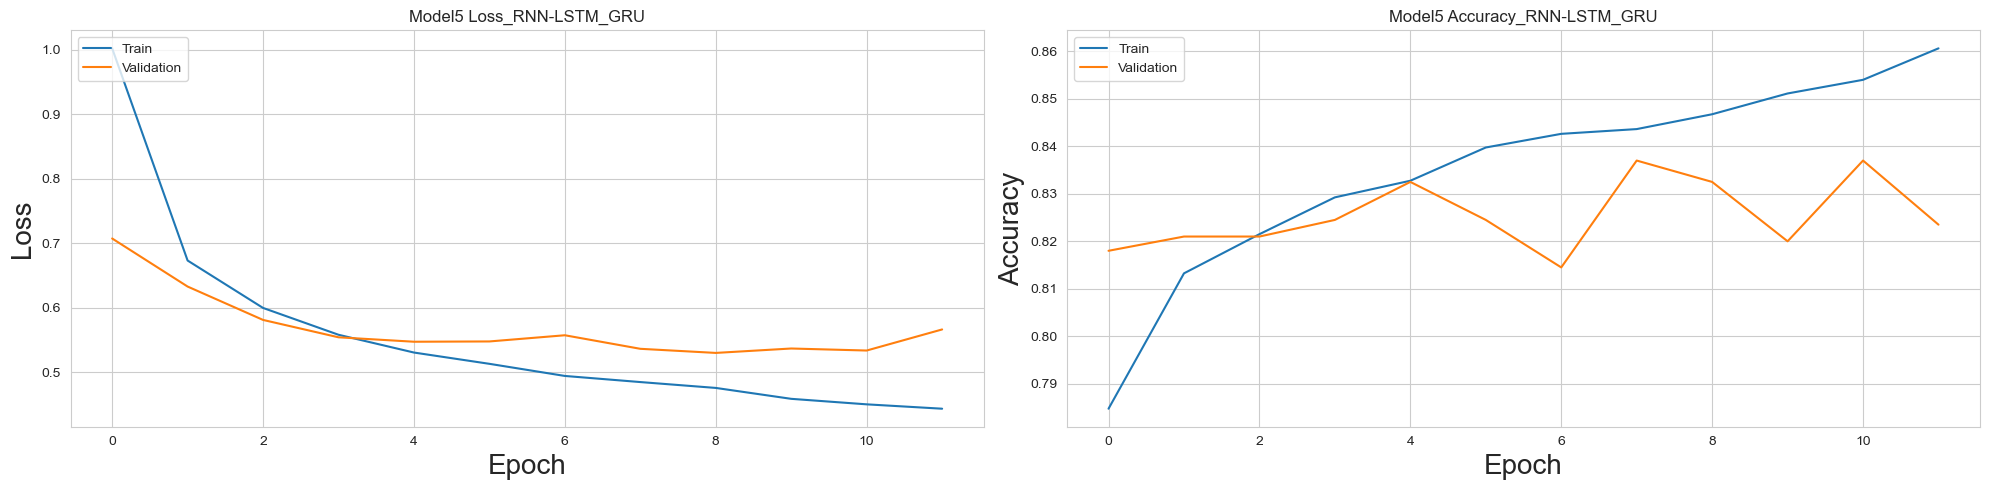

In [236]:
# Extracting loss and accuracy values from history5 DataFrame
training_loss = history5_df['loss']
val_loss = history5_df['val_loss']
training_accuracy = history5_df['accuracy']
val_accuracy = history5_df['val_accuracy']

# Plotting the loss
fig18_1, ax18_1 = plt.subplots(1, 2, figsize=(20, 5))
ax18_1[0].plot(training_loss)
ax18_1[0].plot(val_loss)
ax18_1[0].set_xlabel('Epoch', fontsize=20)
ax18_1[0].set_ylabel('Loss', fontsize=20)
ax18_1[0].set_title('Model5 Loss_RNN-LSTM_GRU')
ax18_1[0].legend(['Train', 'Validation'], loc='upper left')

# Plotting the accuracy
ax18_1[1].plot(training_accuracy)
ax18_1[1].plot(val_accuracy)
ax18_1[1].set_xlabel('Epoch', fontsize=20)
ax18_1[1].set_ylabel('Accuracy', fontsize=20)
ax18_1[1].set_title('Model5 Accuracy_RNN-LSTM_GRU')
ax18_1[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()


In [171]:
# Evaluate the model
loss, accuracy = model_with_gru.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy Model4:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8485 - loss: 0.5110
Test Loss: 0.5301723480224609
Test Accuracy Model4: 0.8324999809265137


In [172]:
# Evaluate the model
y_pred = model_with_gru.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step
Precision: 0.7909680181379549
Recall: 0.8325
F1-score: 0.8028125636557389


In [173]:
# Predict labels for test data
y_pred = model_with_gru.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Simple RNN-LSTM Confusion model_with_gru:")
print(conf_matrix)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step
Simple RNN-LSTM Confusion model_with_gru:
[[ 177    4  101]
 [  45    4  107]
 [  71    7 1484]]


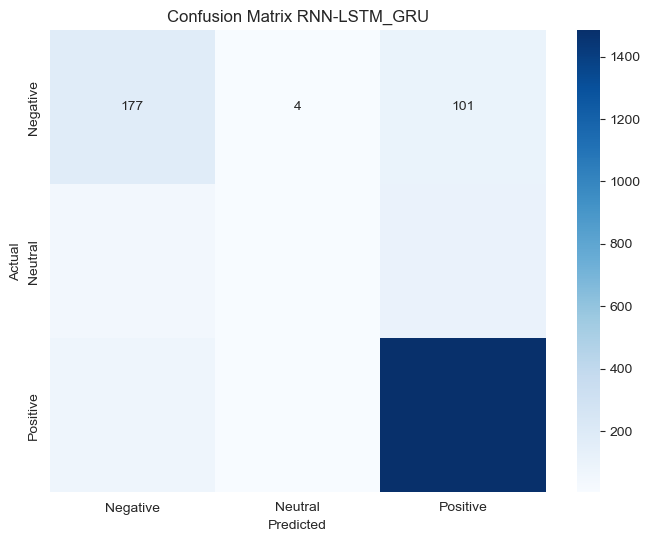

In [174]:
# Visualizing confusion matrix as a heatmap
fig19_1, ax19_1 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax19_1)
ax19_1.set_xlabel('Predicted')
ax19_1.set_ylabel('Actual')
ax19_1.set_title('Confusion Matrix RNN-LSTM_GRU')

# Show the plot
plt.show()

In [175]:
# Get predicted probabilities
y_pred_probs = model_with_gru.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC Score Model- LSTM_GRU:", auc_score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
AUC Score Model- LSTM_GRU: 0.844678577596313


##### Models Ensembling

In [176]:
# Predictions from the first model
y_pred_model1 = model1.predict(X_test)
# Predictions from the second model
y_pred_model2 = model2.predict(X_test)
# Predictions from the third model
y_pred_model3 = model3.predict(X_test)
y_pred_model4 = model4.predict(X_test)
y_pred_model5 = model_with_gru.predict(X_test)

# Average the predictions
y_pred_ensemble = (y_pred_model1 + y_pred_model2 + y_pred_model3 + y_pred_model4 + y_pred_model5) / 5

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


In [177]:
# Convert predictions to labels
y_pred_labels_ensemble = np.argmax(y_pred_ensemble, axis=1)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_labels_ensemble)
print("Ensemble Model Accuracy:", accuracy_ensemble)

Ensemble Model Accuracy: 0.837


### CNN Model for sentiment analysis

In [178]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D

In [179]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Add a 1D convolutional layer
conv1d_layer1 = Conv1D(64, 3, activation='relu')(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer
conv1d_layer2 = Conv1D(64, 3, activation='relu')(maxpooling_layer)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(conv1d_layer2)

# Add a dense layer
dense_layer1 = Dense(64, activation='relu')(global_maxpooling_layer)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer1)

# Build the model
model1_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model1_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model1_cnn.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 64)              │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,698,571 (120.92 MB)

 Trainable params: 55,171 (215.51 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [180]:
# Train the model
history1_cnn = model1_cnn.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7538 - loss: 0.6997 - val_accuracy: 0.8070 - val_loss: 0.5339
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8194 - loss: 0.4878 - val_accuracy: 0.8235 - val_loss: 0.4952
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8494 - loss: 0.4038 - val_accuracy: 0.8175 - val_loss: 0.5006
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8927 - loss: 0.2923 - val_accuracy: 0.8195 - val_loss: 0.5169
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9353 - loss: 0.2049 - val_accuracy: 0.8030 - val_loss: 0.5705
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9648 - loss: 0.1239 - val_accuracy: 0.8180 - val_loss: 0.6503
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9841 - loss: 0.0634 - val_accuracy: 0.7975 - val_loss: 0.7363
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9965 - loss: 0.0297 - val_accu

In [181]:
history1_cnn_df = pd.DataFrame(history1_cnn.history)
history1_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.774000,0.633662,0.8070,0.533907
1,0.822500,0.481057,0.8235,0.495164
2,0.853375,0.396753,0.8175,0.500596
3,0.889750,0.303091,0.8195,0.516863
4,0.932250,0.206042,0.8030,0.570543
5,0.960375,0.127138,0.8180,0.650330
6,0.982125,0.067514,0.7975,0.736286
7,0.994250,0.034069,0.8170,0.892300
8,0.998000,0.017725,0.8205,0.941799
9,0.999125,0.007699,0.8140,0.957170


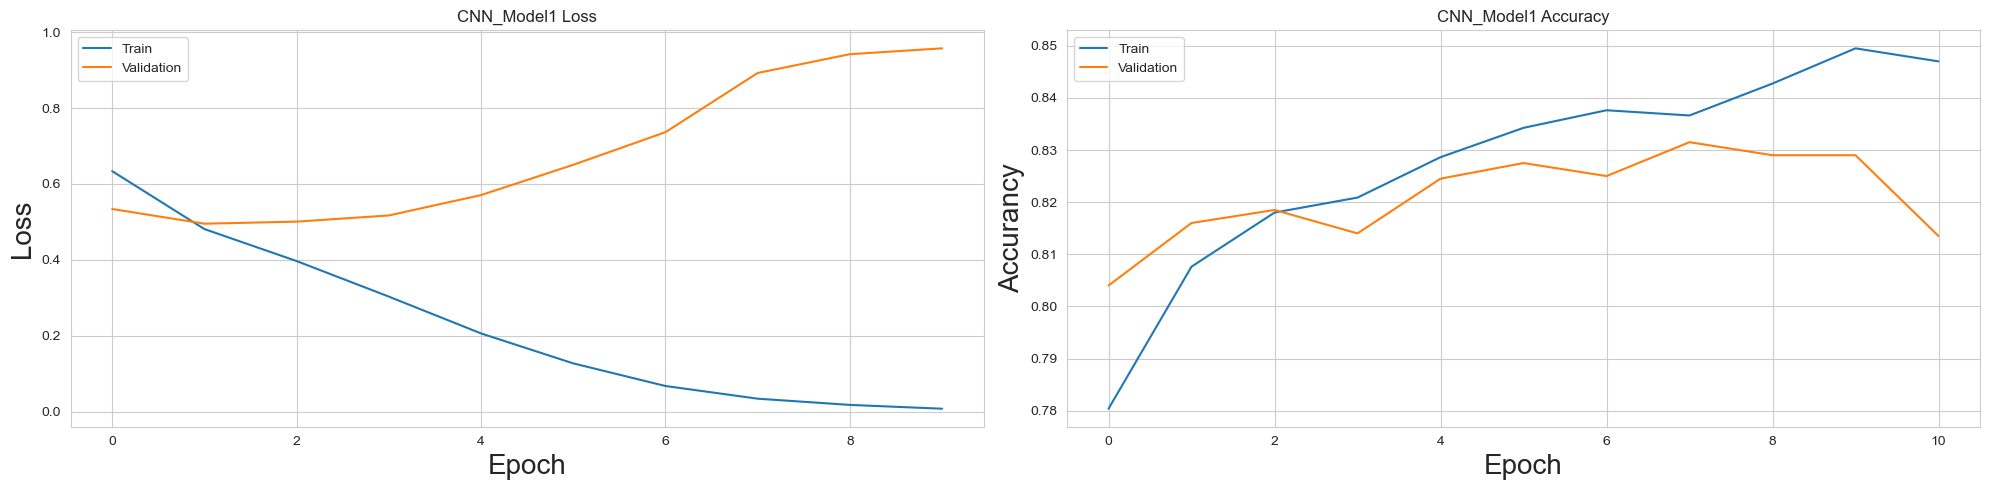

In [182]:
training_loss = history1_cnn_df['loss']
val_loss = history1_cnn_df['val_loss']
training_accuracy = history1_cnn_df['accuracy']
val_accuracy = history1_cnn_df ['val_accuracy']

#plot the loss
fig21, ax21 = plt.subplots(1,2, figsize =(20,5))
ax21[0].plot(training_loss)
ax21[0].plot(val_loss)
ax21[0].set_xlabel('Epoch', fontsize =20)
ax21[0].set_ylabel('Loss', fontsize =20)
ax21[0].set_title('CNN_Model1 Loss')
ax21[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax21[1].plot(training_accurancy)
ax21[1].plot(val_accurancy )
ax21[1].set_xlabel('Epoch', fontsize =20)
ax21[1].set_ylabel('Accurancy', fontsize =20)
ax21[1].set_title('CNN_Model1 Accuracy')
ax21[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [183]:
# Make predictions
y_pred = model1_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy Model1_CNN:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy Model1_CNN: 0.814


In [184]:
# Calculate F1 score, recall, and precision
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       282
           1       0.26      0.12      0.17       156
           2       0.88      0.93      0.90      1562

    accuracy                           0.81      2000
   macro avg       0.57      0.54      0.55      2000
weighted avg       0.79      0.81      0.80      2000



In [185]:
# Evaluate the model
y_pred = model1_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precision: 0.7873924544673339
Recall: 0.814
F1-score: 0.798250232298131


In [186]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Simple CNN Confusion model:")
print(conf_matrix)

Simple CNN Confusion model:
[[ 160   22  100]
 [  34   19  103]
 [  80   33 1449]]


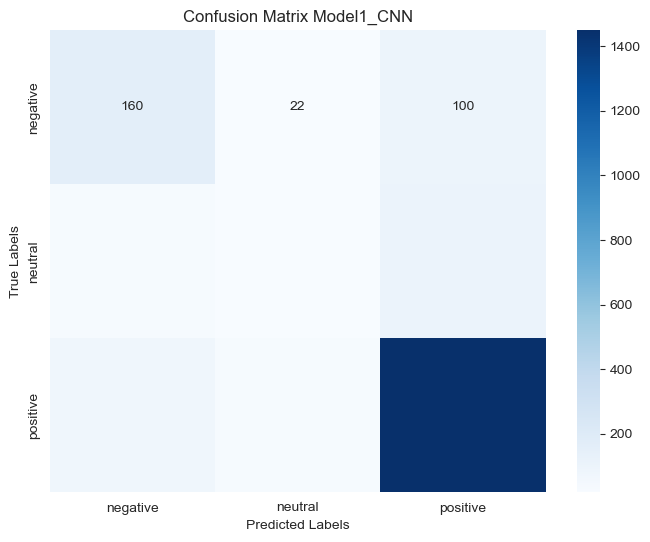

In [187]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']  # Modify this according to your classes
fig22, ax22 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax22)
ax22.set_xlabel('Predicted Labels')
ax22.set_ylabel('True Labels')
ax22.set_title('Confusion Matrix Model1_CNN')
plt.show()

In [188]:
# Get predicted probabilities
y_pred_probs = model1_cnn.predict(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate AUC score per class
auc_scores = []

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# Calculate micro-average AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print AUC scores per class
for i, auc_score in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score}")

# Print micro-average AUC score
print("Micro-average AUC Model1_CNN:", roc_auc_micro)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC for class 0: 0.8798970434035949
AUC for class 1: 0.7349164302797708
AUC for class 2: 0.8562323505165489
Micro-average AUC Model1_CNN: 0.9315998125


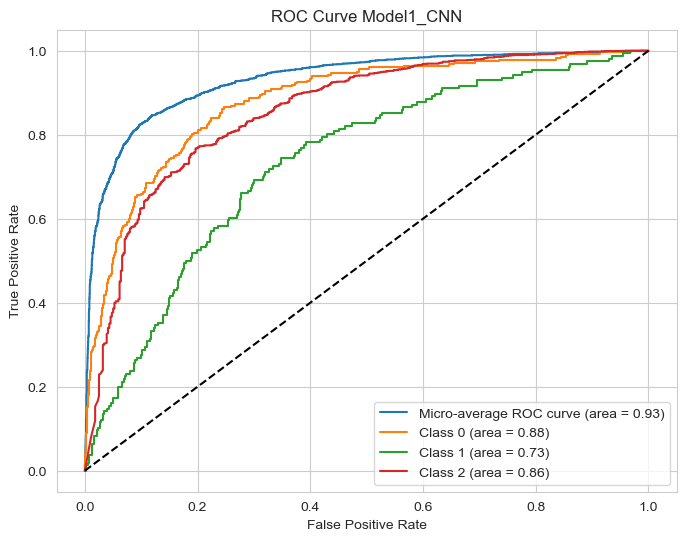

In [189]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-averaged ROC curve
fig23, ax23 = plt.subplots(figsize=(8, 6))
ax23.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

# Plot ROC curve for each class
for i in range(3):
    ax23.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

ax23.plot([0, 1], [0, 1], 'k--')
ax23.set_xlabel('False Positive Rate')
ax23.set_ylabel('True Positive Rate')
ax23.set_title('ROC Curve Model1_CNN')
ax23.legend(loc='best')
plt.show()

#### Optimization 1
I added a kernel size of 5 to the Conv1D layer with 128 size


In [190]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Add a 1D convolutional layer
conv1d_layer1 = Conv1D(128, 5, activation='relu')(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer
conv1d_layer2 = Conv1D(128, 5, activation='relu')(maxpooling_layer)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(conv1d_layer2)

# Add a dense layer
dense_layer1 = Dense(128, activation='relu')(global_maxpooling_layer)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer1)

# Build the model
model2_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model2_cnn.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 96, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 15, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,870,475 (121.58 MB)

 Trainable params: 227,075 (887.01 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [191]:
# Train the model
history2_cnn = model2_cnn.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7507 - loss: 0.7053 - val_accuracy: 0.8180 - val_loss: 0.5022
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8265 - loss: 0.4740 - val_accuracy: 0.8300 - val_loss: 0.4639
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8668 - loss: 0.3613 - val_accuracy: 0.8255 - val_loss: 0.4846
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9250 - loss: 0.2174 - val_accuracy: 0.8110 - val_loss: 0.5790
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9740 - loss: 0.0931 - val_accuracy: 0.8250 - val_loss: 0.6502
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9886 - loss: 0.0432 - val_accuracy: 0.8110 - val_loss: 0.8194
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9994 - loss: 0.0097 - val_accuracy: 0.8165 - val_loss: 0.9459
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 1.0000 - loss: 0.0017 - val_

In [192]:
history2_cnn_df = pd.DataFrame(history2_cnn.history)
history2_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.782125,0.620990,0.8180,0.502208
1,0.829375,0.464102,0.8300,0.463873
2,0.869250,0.355396,0.8255,0.484612
3,0.926750,0.213044,0.8110,0.579022
4,0.969500,0.099914,0.8250,0.650207
5,0.992750,0.033959,0.8110,0.819378
6,0.999500,0.007569,0.8165,0.945920
7,0.999875,0.001815,0.8105,0.929850
8,1.000000,0.000782,0.8130,0.992555
9,1.000000,0.000435,0.8105,1.055977


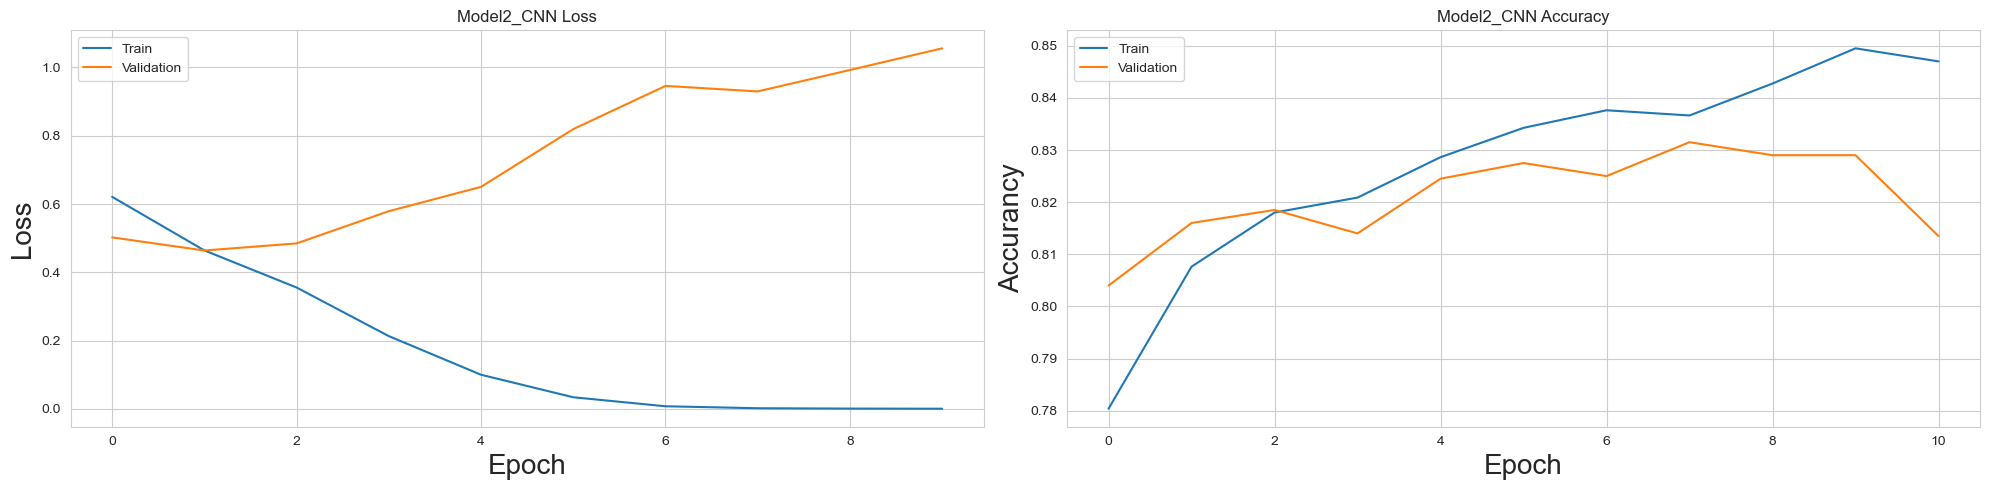

In [193]:
training_loss = history2_cnn_df['loss']
val_loss = history2_cnn_df['val_loss']
training_accuracy = history2_cnn_df['accuracy']
val_accuracy =  history2_cnn_df['val_accuracy']

#plot the loss
fig24, ax24 = plt.subplots(1,2, figsize =(20,5))
ax24[0].plot(training_loss)
ax24[0].plot(val_loss)
ax24[0].set_xlabel('Epoch', fontsize =20)
ax24[0].set_ylabel('Loss', fontsize =20)
ax24[0].set_title('Model2_CNN Loss')
ax24[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax24[1].plot(training_accurancy)
ax24[1].plot(val_accurancy )
ax24[1].set_xlabel('Epoch', fontsize =20)
ax24[1].set_ylabel('Accurancy', fontsize =20)
ax24[1].set_title('Model2_CNN Accuracy')
ax24[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [194]:
# Make predictions
y_pred = model2_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy Model2_CNN:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Accuracy Model2_CNN: 0.8105


In [195]:
# Calculate F1 score, recall, and precision
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       282
           1       0.20      0.10      0.14       156
           2       0.87      0.93      0.90      1562

    accuracy                           0.81      2000
   macro avg       0.55      0.52      0.53      2000
weighted avg       0.78      0.81      0.79      2000



In [196]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Simple CNN Confusion model:")
print(conf_matrix)

Simple CNN Confusion model:
[[ 146   25  111]
 [  37   16  103]
 [  63   40 1459]]


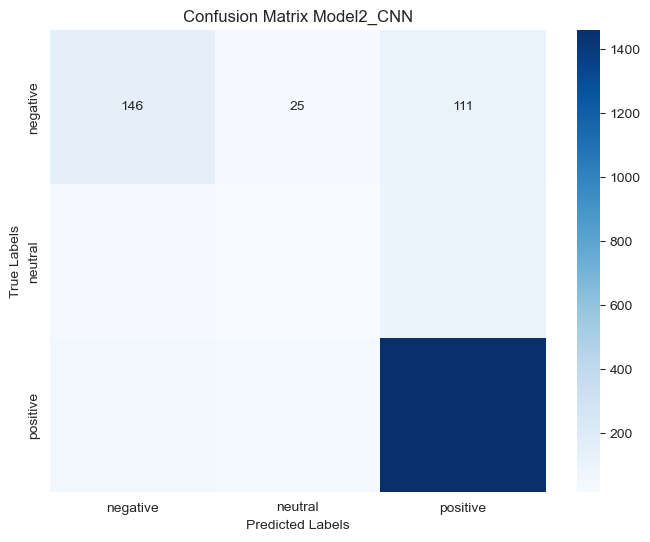

In [197]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']
fig25, ax25 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax25)
ax25.set_xlabel('Predicted Labels')
ax25.set_ylabel('True Labels')
ax25.set_title('Confusion Matrix Model2_CNN')
plt.show()

In [198]:
# Get predicted probabilities
y_pred_probs = model2_cnn.predict(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate AUC score per class
auc_scores = []

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# Calculate micro-average AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print AUC scores per class
for i, auc_score in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score}")

# Print micro-average AUC score
print("Micro-average AUC Model2_CNN:", roc_auc_micro)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
AUC for class 0: 0.8978545892882207
AUC for class 1: 0.7507508760220257
AUC for class 2: 0.8694712901735862
Micro-average AUC Model2_CNN: 0.9362233750000001


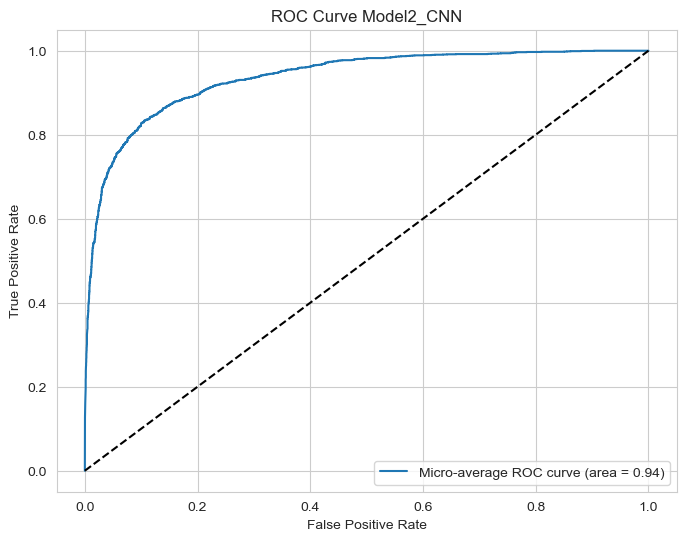

In [199]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-averaged ROC curve
fig26, ax26 = plt.subplots(figsize=(8, 6))
ax26.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

# Plot ROC curve for each class
for i in range(3):
    ax23.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

ax26.plot([0, 1], [0, 1], 'k--')
ax26.set_xlabel('False Positive Rate')
ax26.set_ylabel('True Positive Rate')
ax26.set_title('ROC Curve Model2_CNN')
ax26.legend(loc='best')
plt.show()

#### Optimization 2
This model includes L2 regularization on the convolutional and dense layers, a dropout layer with a dropout rate of 0.3, and an average pooling layer after the second convolutional layer. Additionally, it uses a reduced learning rate of 0.0001 for the Adam optimizer.

In [200]:
from keras.layers import AveragePooling1D

In [201]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Add a 1D convolutional layer with L2 regularization
conv1d_layer1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer with L2 regularization
conv1d_layer2 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(maxpooling_layer)

# Add an average pooling layer
averagepooling_layer = AveragePooling1D(3)(conv1d_layer2)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(averagepooling_layer)

# Add a dropout layer
dropout_layer = Dropout(0.3)(global_maxpooling_layer)

# Add a dense layer with L2 regularization
dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout_layer)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer1)

# Build the model
model3_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a reduced learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model3_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model3_cnn.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 15, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,870,475 (121.58 MB)

 Trainable params: 227,075 (887.01 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [202]:
# Train the model
history3_cnn = model3_cnn.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.6820 - loss: 1.2447 - val_accuracy: 0.7810 - val_loss: 1.0416
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7706 - loss: 1.0583 - val_accuracy: 0.7810 - val_loss: 0.9712
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7711 - loss: 0.9873 - val_accuracy: 0.7860 - val_loss: 0.9106
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7935 - loss: 0.9086 - val_accuracy: 0.8110 - val_loss: 0.8627
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8078 - loss: 0.8529 - val_accuracy: 0.8125 - val_loss: 0.8327
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8214 - loss: 0.8114 - val_accuracy: 0.8225 - val_loss: 0.8128
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8344 - loss: 0.7697 - val_accuracy: 0.8280 - val_loss: 0.8017
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8379 - loss: 0.7427 - val

In [203]:
history3_cnn_df = pd.DataFrame(history3_cnn.history)
history3_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.752375,1.148003,0.7810,1.041591
1,0.773875,1.035445,0.7810,0.971237
2,0.780125,0.961212,0.7860,0.910565
3,0.796875,0.894992,0.8110,0.862690
4,0.811500,0.848027,0.8125,0.832720
5,0.822875,0.806531,0.8225,0.812794
6,0.829875,0.775541,0.8280,0.801679
7,0.838750,0.741721,0.8230,0.803125
8,0.844500,0.711266,0.8295,0.784183
9,0.856250,0.679666,0.8250,0.774698


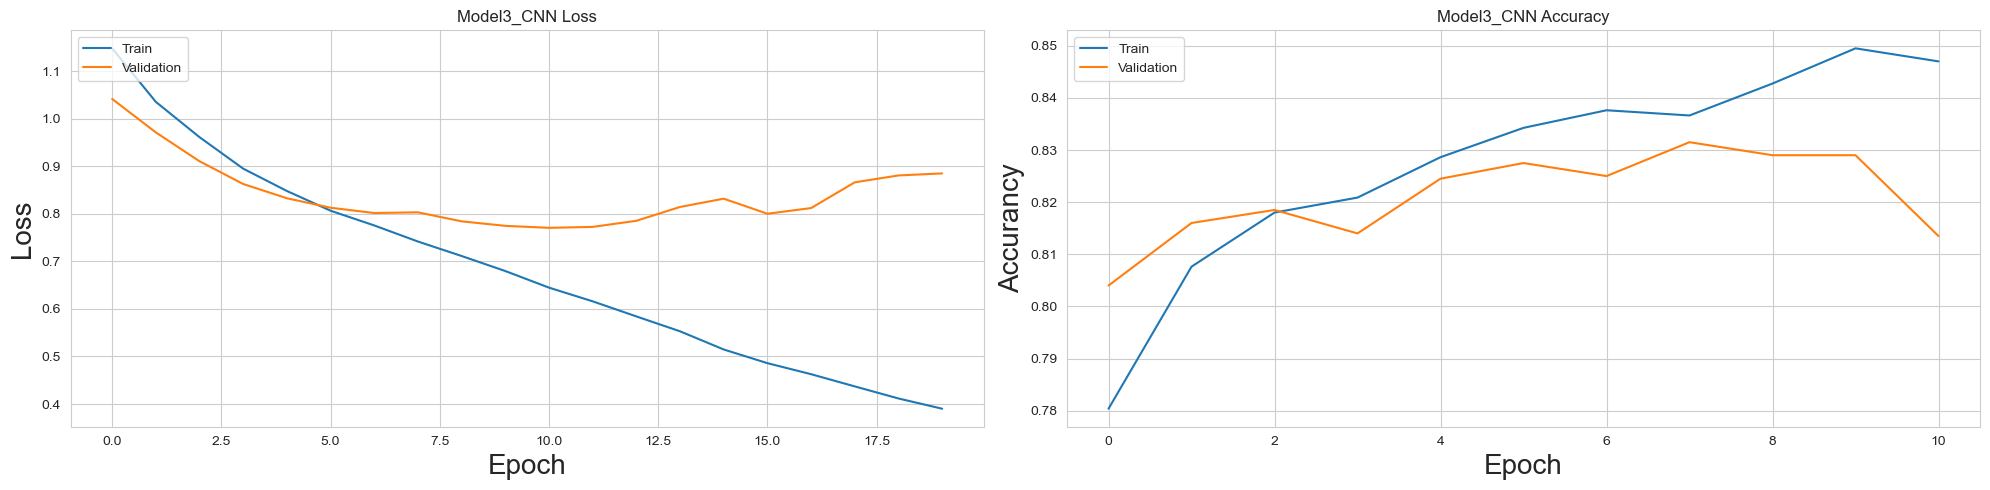

In [204]:
training_loss = history3_cnn_df['loss']
val_loss = history3_cnn_df['val_loss']
training_accuracy = history3_cnn_df['accuracy']
val_accuracy =  history3_cnn_df['val_accuracy']

#plot the loss
fig27, ax27 = plt.subplots(1,2, figsize =(20,5))
ax27[0].plot(training_loss)
ax27[0].plot(val_loss)
ax27[0].set_xlabel('Epoch', fontsize =20)
ax27[0].set_ylabel('Loss', fontsize =20)
ax27[0].set_title('Model3_CNN Loss')
ax27[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax27[1].plot(training_accurancy)
ax27[1].plot(val_accurancy )
ax27[1].set_xlabel('Epoch', fontsize =20)
ax27[1].set_ylabel('Accurancy', fontsize =20)
ax27[1].set_title('Model3_CNN Accuracy')
ax27[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [205]:
# Make predictions
y_pred = model3_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy Model3_CNN:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Accuracy Model3_CNN: 0.809


In [206]:
# Calculate F1 score, recall, and precision
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       282
           1       0.21      0.15      0.18       156
           2       0.87      0.94      0.90      1562

    accuracy                           0.81      2000
   macro avg       0.57      0.52      0.54      2000
weighted avg       0.79      0.81      0.79      2000



In [207]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix_model3:")
print(conf_matrix)

Confusion Matrix_model3:
[[ 132   37  113]
 [  31   24  101]
 [  47   53 1462]]


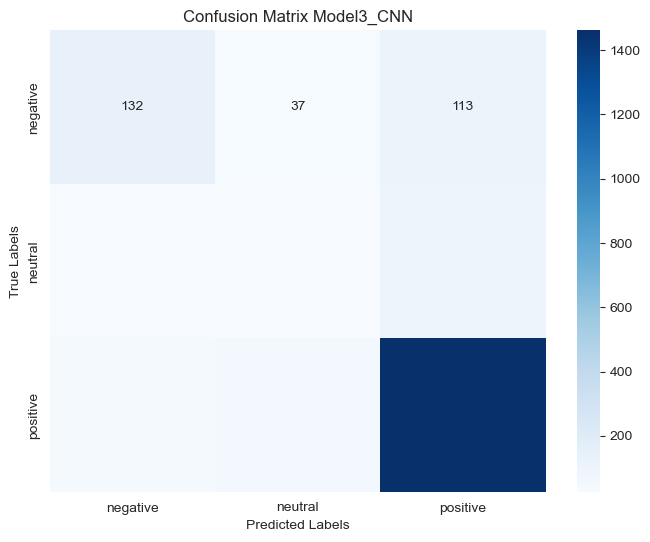

In [208]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']
fig28, ax28 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax28)
ax28.set_xlabel('Predicted Labels')
ax28.set_ylabel('True Labels')
ax28.set_title('Confusion Matrix Model3_CNN')
plt.show()

In [209]:
# Get predicted probabilities
y_pred_probs = model3_cnn.predict(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate AUC score per class
auc_scores = []

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# Calculate micro-average AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print AUC scores per class
for i, auc_score in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score}")

# Print micro-average AUC score
print("Micro-average AUC Model3_CNN:", roc_auc_micro)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
AUC for class 0: 0.8740577448624907
AUC for class 1: 0.7555863785527559
AUC for class 2: 0.8603659106987296
Micro-average AUC Model3_CNN: 0.9286981875


##### Optimised 3
L1/L2 regularization on the convolutional layers and dense layers.
Dropout layer with a dropout rate of 0.5 after global max pooling.
Another dense layer with 64 units.
Early stopping callback to prevent overfitting.

In [237]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Add a 1D convolutional layer with L1/L2 regularization
conv1d_layer1 = Conv1D(64, 3, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer with L1/L2 regularization
conv1d_layer2 = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(maxpooling_layer)

# Add an average pooling layer
averagepooling_layer = AveragePooling1D(3)(conv1d_layer2)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(averagepooling_layer)

# Add a dropout layer with a dropout rate of 0.5
dropout_layer = Dropout(0.5)(global_maxpooling_layer)

# Add a dense layer with L1/L2 regularization
dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(dropout_layer)

# Add another dense layer
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer2)

# Build the model
model4_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a reduced learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model4_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model4_cnn.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_12 (Embedding)             │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 98, 64)              │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 15, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_4                  │ (None, 5, 128)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,747,915 (121.11 MB)

 Trainable params: 104,515 (408.26 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [238]:
# Train the model with early stopping
history4_cnn = model4_cnn.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7238 - loss: 5.5196 - val_accuracy: 0.7810 - val_loss: 4.8245
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7719 - loss: 4.6809 - val_accuracy: 0.7810 - val_loss: 4.1275
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7789 - loss: 3.9918 - val_accuracy: 0.7810 - val_loss: 3.5215
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7703 - loss: 3.4156 - val_accuracy: 0.7810 - val_loss: 2.9910
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7781 - loss: 2.8881 - val_accuracy: 0.7810 - val_loss: 2.5233
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7729 - loss: 2.4502 - val_accuracy: 0.7810 - val_loss: 2.1344
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7737 - loss: 2.0789 - val_accuracy: 0.7810 - val_loss: 1.8238
Epoch 8/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7732 - loss: 1.7889 - val_accu

In [239]:
history4_cnn_df = pd.DataFrame(history4_cnn.history)
history4_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.763000,5.277494,0.7810,4.824495
1,0.774000,4.502162,0.7810,4.127485
2,0.774000,3.850666,0.7810,3.521535
3,0.774000,3.276037,0.7810,2.990967
4,0.774000,2.779902,0.7810,2.523314
5,0.774000,2.352348,0.7810,2.134431
6,0.774000,2.001333,0.7810,1.823845
7,0.774000,1.721695,0.7810,1.578815
8,0.774000,1.505807,0.7810,1.389355
9,0.774000,1.335780,0.7830,1.247168


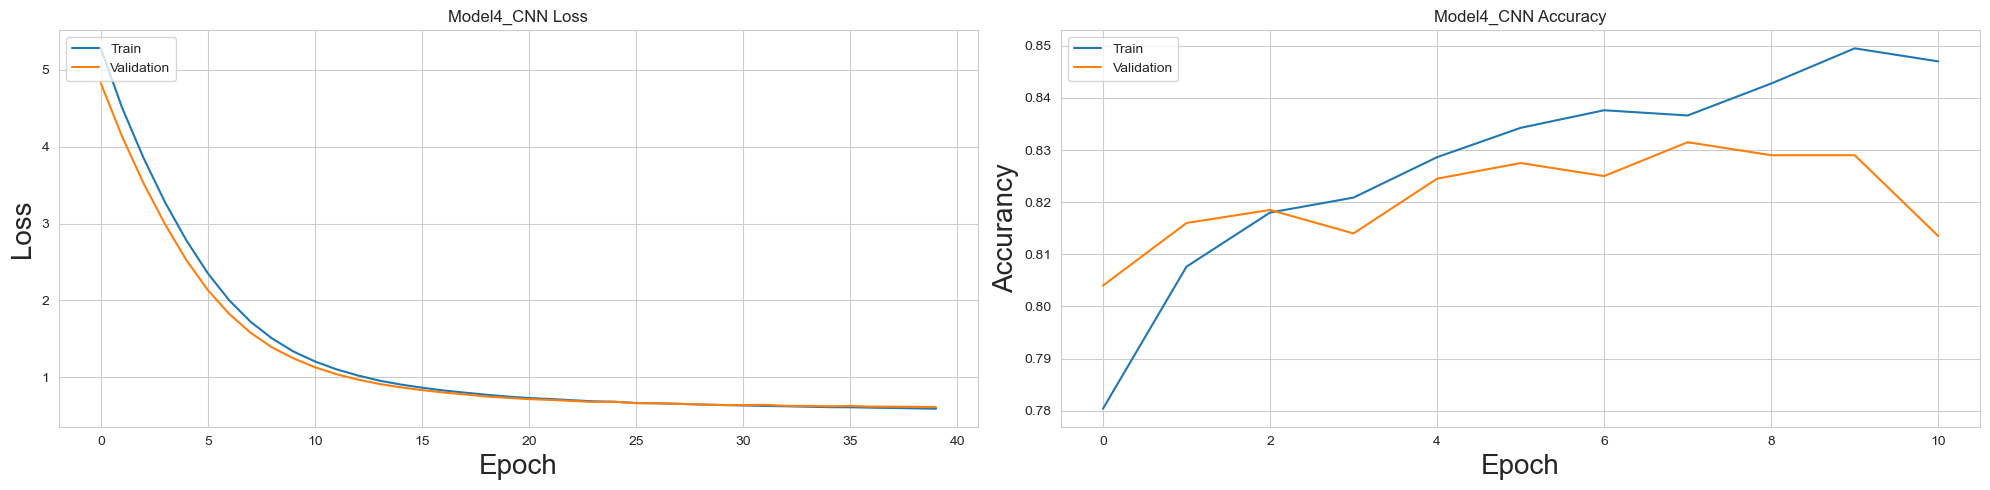

In [240]:
training_loss = history4_cnn_df['loss']
val_loss = history4_cnn_df['val_loss']
training_accuracy = history4_cnn_df['accuracy']
val_accuracy =  history4_cnn_df['val_accuracy']

#plot the loss
fig29, ax29 = plt.subplots(1,2, figsize =(20,5))
ax29[0].plot(training_loss)
ax29[0].plot(val_loss)
ax29[0].set_xlabel('Epoch', fontsize =20)
ax29[0].set_ylabel('Loss', fontsize =20)
ax29[0].set_title('Model4_CNN Loss')
ax29[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax29[1].plot(training_accurancy)
ax29[1].plot(val_accurancy )
ax29[1].set_xlabel('Epoch', fontsize =20)
ax29[1].set_ylabel('Accurancy', fontsize =20)
ax29[1].set_title('Model4_CNN Accuracy')
ax29[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [241]:
# Predict labels for the test data
y_pred = model4_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy Model4_CNN:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy Model4_CNN: 0.821


In [242]:
# Generate classification report
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.46      0.53       282
           1       0.00      0.00      0.00       156
           2       0.84      0.97      0.90      1562

    accuracy                           0.82      2000
   macro avg       0.49      0.48      0.48      2000
weighted avg       0.75      0.82      0.78      2000



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix_model4:")
print(conf_matrix)

Confusion Matrix_model4:
[[ 130    0  152]
 [  28    0  128]
 [  50    0 1512]]


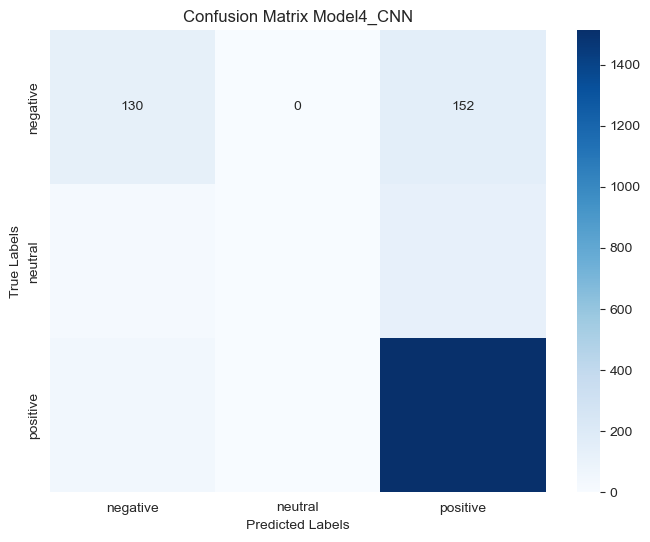

In [244]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']
fig30, ax30 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax30)
ax30.set_xlabel('Predicted Labels')
ax30.set_ylabel('True Labels')
ax30.set_title('Confusion Matrix Model4_CNN')
plt.show()

In [245]:
# Get predicted probabilities
y_pred_probs = model4_cnn.predict(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate AUC score per class
auc_scores = []

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# Calculate micro-average AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print AUC scores per class
for i, auc_score in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score}")

# Print micro-average AUC score
print("Micro-average AUC Model4_CNN:", roc_auc_micro)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC for class 0: 0.8849870788233059
AUC for class 1: 0.7220194393459034
AUC for class 2: 0.8655701331275323
Micro-average AUC Model4_CNN: 0.93598275


##### Incorporating AVerage Pooling 

In [246]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer with trainable embeddings
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

# Add a 1D convolutional layer with L1/L2 regularization
conv1d_layer1 = Conv1D(64, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer with L1/L2 regularization
conv1d_layer2 = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(maxpooling_layer)

# Add an average pooling layer
averagepooling_layer = AveragePooling1D(5)(conv1d_layer2)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(averagepooling_layer)

# Add a dropout layer with a dropout rate of 0.5
dropout_layer = Dropout(0.5)(global_maxpooling_layer)

# Add a dense layer with L1/L2 regularization
dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(dropout_layer)

# Add another dense layer
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer2)

# Build the model
model_finetuned = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a reduced learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model_finetuned.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model_finetuned.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_13 (Embedding)             │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 96, 64)              │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 15, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_5                  │ (None, 3, 128)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_7               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,773,515 (121.21 MB)

 Trainable params: 31,773,515 (121.21 MB)

 Non-trainable params: 0 (0.00 B)

In [247]:
# Train the model with early stopping
history5_cnn = model_finetuned.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.7283 - loss: 5.9547 - val_accuracy: 0.7810 - val_loss: 5.1201
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.7764 - loss: 4.9235 - val_accuracy: 0.7810 - val_loss: 4.2590
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.7722 - loss: 4.0930 - val_accuracy: 0.7810 - val_loss: 3.5133
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.7747 - loss: 3.3688 - val_accuracy: 0.7810 - val_loss: 2.8843
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.7747 - loss: 2.7742 - val_accuracy: 0.7810 - val_loss: 2.3755
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.7775 - loss: 2.2923 - val_accuracy: 0.7860 - val_loss: 1.9805
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.7849 - loss: 1.9116 - val_accuracy: 0.8030 - val_loss: 1.7005
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.7833 - loss: 1

In [248]:
history5_cnn_df = pd.DataFrame(history5_cnn.history)
history5_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.763625,5.670184,0.7810,5.120079
1,0.774000,4.710013,0.7810,4.258974
2,0.774000,3.905739,0.7810,3.513282
3,0.774000,3.215699,0.7810,2.884302
4,0.774000,2.648038,0.7810,2.375483
5,0.775750,2.193354,0.7860,1.980519
6,0.782375,1.847641,0.8030,1.700544
7,0.790125,1.594308,0.7990,1.485457
8,0.800750,1.403610,0.8210,1.341937
9,0.811250,1.249224,0.8170,1.188440


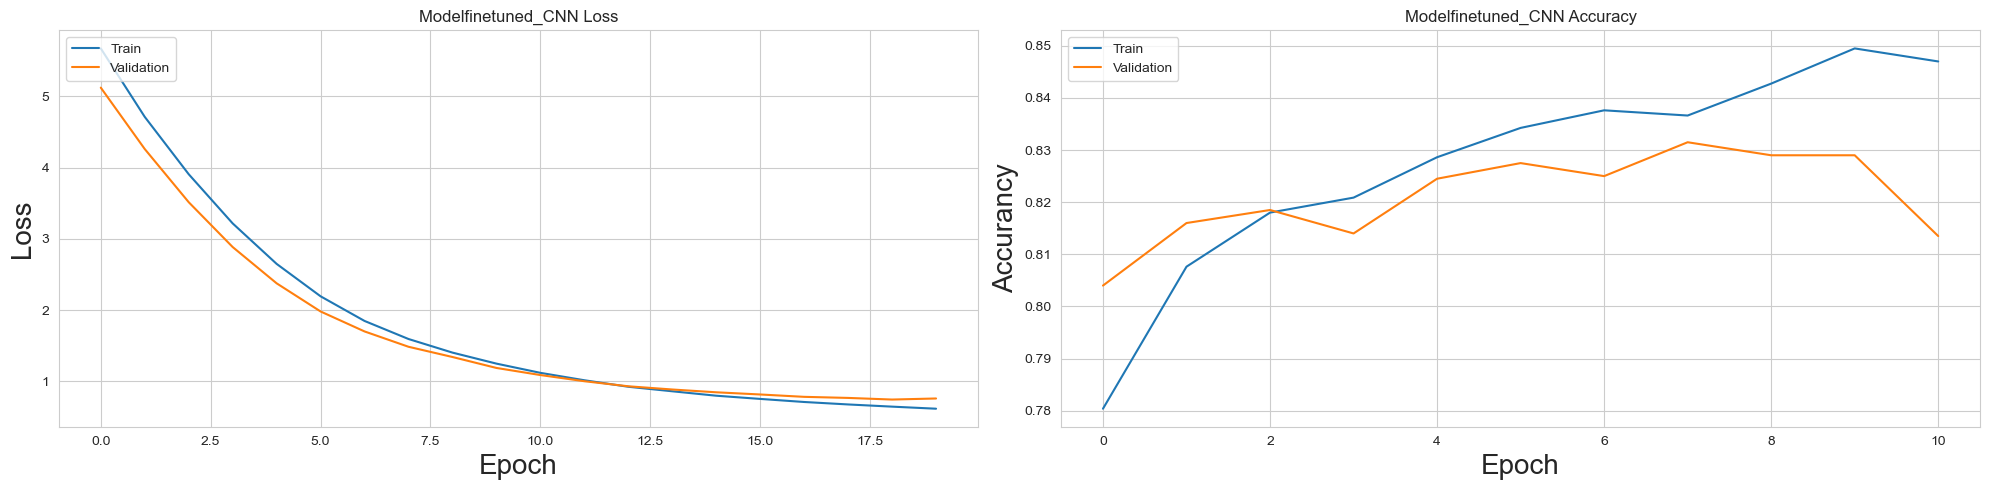

In [249]:
training_loss = history5_cnn_df['loss']
val_loss = history5_cnn_df['val_loss']
training_accuracy = history5_cnn_df['accuracy']
val_accuracy =  history5_cnn_df['val_accuracy']

#plot the loss
fig31, ax31 = plt.subplots(1,2, figsize =(20,5))
ax31[0].plot(training_loss)
ax31[0].plot(val_loss)
ax31[0].set_xlabel('Epoch', fontsize =20)
ax31[0].set_ylabel('Loss', fontsize =20)
ax31[0].set_title('Modelfinetuned_CNN Loss')
ax31[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax31[1].plot(training_accurancy)
ax31[1].plot(val_accurancy )
ax31[1].set_xlabel('Epoch', fontsize =20)
ax31[1].set_ylabel('Accurancy', fontsize =20)
ax31[1].set_title('Modelfinetuned_CNN Accuracy')
ax31[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [250]:
# Predict labels for the test data
y_pred = model_finetuned.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [251]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

Accuracy: 0.8315
Precision: 0.7581888143043841
Recall: 0.8315
F1-score: 0.7911157274427468


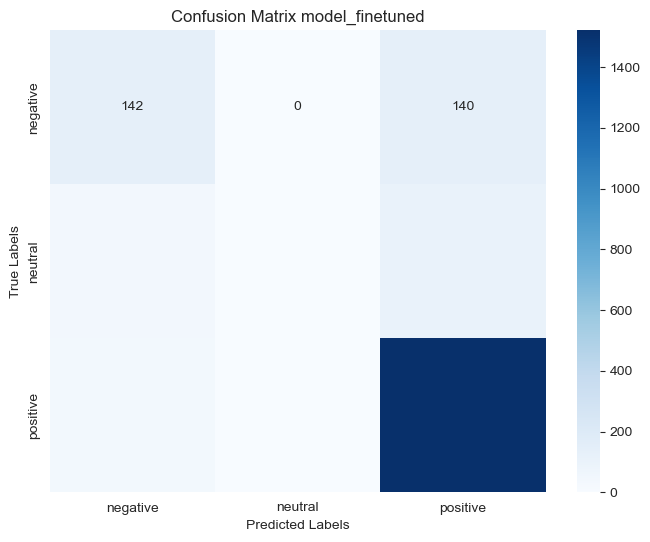

In [252]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']
fig32, ax32 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax32)
ax32.set_xlabel('Predicted Labels')
ax32.set_ylabel('True Labels')
ax32.set_title('Confusion Matrix model_finetuned')
plt.show()

##### Incorporating SMOTE to address the under sampling above

In [253]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Define and train the model
subset_size = 10000 
X_sub = X_padded[:subset_size] 
y_sub = y[:subset_size] 

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

In [254]:
# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add an embedding layer
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Add a 1D convolutional layer with L2 regularization
conv1d_layer1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(embedding_layer)

# Add a max pooling layer
maxpooling_layer = MaxPooling1D(5)(conv1d_layer1)

# Add another 1D convolutional layer with L2 regularization
conv1d_layer2 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(maxpooling_layer)

# Add an average pooling layer
averagepooling_layer = AveragePooling1D(3)(conv1d_layer2)

# Add global max pooling
global_maxpooling_layer = GlobalMaxPooling1D()(averagepooling_layer)

# Add a dropout layer
dropout_layer = Dropout(0.2)(global_maxpooling_layer)

# Add a dense layer with L2 regularization
dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout_layer)

# Add the output layer
output_layer = Dense(3, activation='softmax')(dense_layer1)

# Build the model
model_smote_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a reduced learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model_smote_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model_smote_cnn.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_14 (Embedding)             │ (None, 100, 200)            │      31,643,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 96, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 15, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_6                  │ (None, 5, 128)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_8               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,870,475 (121.58 MB)

 Trainable params: 227,075 (887.01 KB)

 Non-trainable params: 31,643,400 (120.71 MB)

In [255]:
# Train the model with early stopping
history6_cnn = model_smote_cnn.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6756 - loss: 1.2415 - val_accuracy: 0.7810 - val_loss: 1.0327
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7736 - loss: 1.0450 - val_accuracy: 0.7810 - val_loss: 0.9512
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7737 - loss: 0.9674 - val_accuracy: 0.8035 - val_loss: 0.8843
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8002 - loss: 0.8793 - val_accuracy: 0.8050 - val_loss: 0.8376
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8223 - loss: 0.8081 - val_accuracy: 0.8155 - val_loss: 0.8145
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8218 - loss: 0.7918 - val_accuracy: 0.8205 - val_loss: 0.8037
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8431 - loss: 0.7463 - val_accuracy: 0.8245 - val_loss: 0.7751
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8432 - loss: 0.7061 - val_accu

In [256]:
history6_cnn_df = pd.DataFrame(history6_cnn.history)
history6_cnn_df

,accuracy,loss,val_accuracy,val_loss
0,0.749375,1.146066,0.7810,1.032675
1,0.774250,1.021335,0.7810,0.951232
2,0.785375,0.934994,0.8035,0.884300
3,0.805500,0.863995,0.8050,0.837631
4,0.818000,0.817285,0.8155,0.814459
5,0.826250,0.784425,0.8205,0.803737
6,0.840375,0.741301,0.8245,0.775087
7,0.846125,0.709791,0.8225,0.766176
8,0.852375,0.680240,0.8265,0.756541
9,0.862375,0.643701,0.8240,0.765262


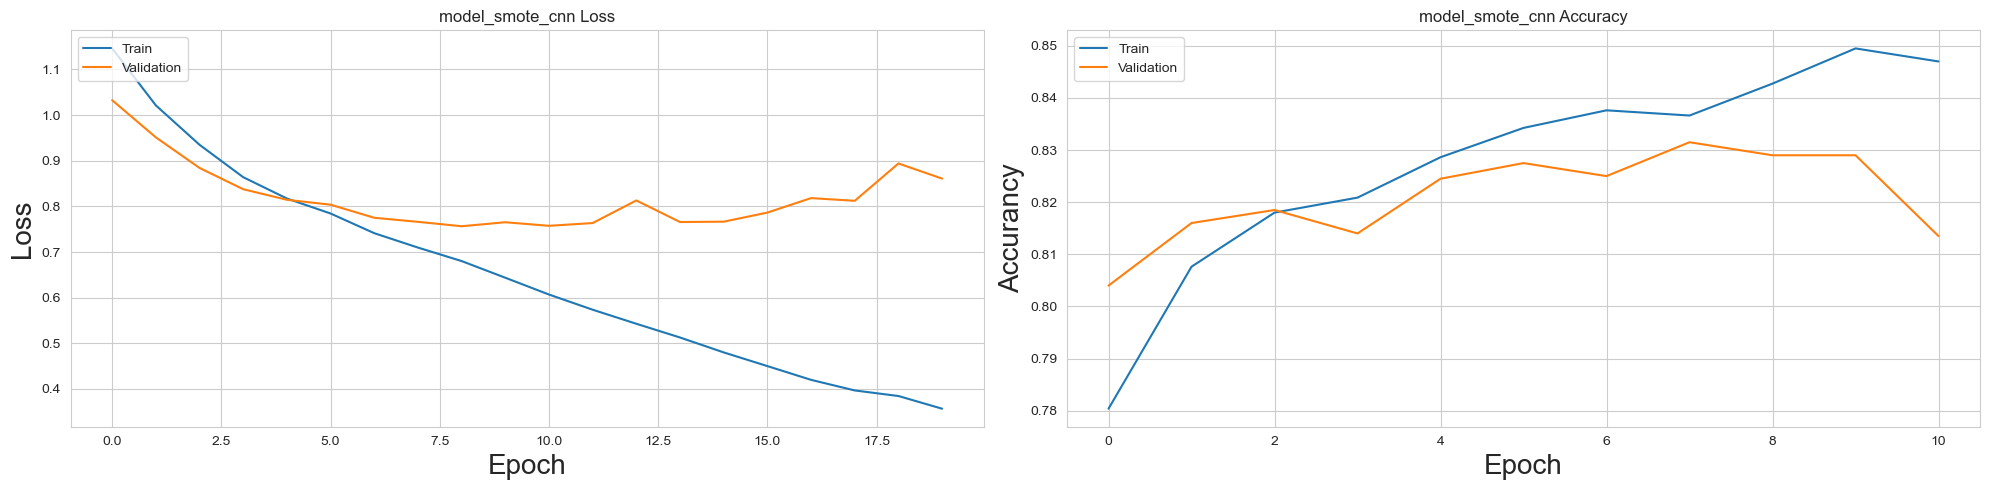

In [257]:
training_loss = history6_cnn_df['loss']
val_loss = history6_cnn_df['val_loss']
training_accuracy = history6_cnn_df['accuracy']
val_accuracy =  history6_cnn_df['val_accuracy']

#plot the loss
fig33, ax33 = plt.subplots(1,2, figsize =(20,5))
ax33[0].plot(training_loss)
ax33[0].plot(val_loss)
ax33[0].set_xlabel('Epoch', fontsize =20)
ax33[0].set_ylabel('Loss', fontsize =20)
ax33[0].set_title('model_smote_cnn Loss')
ax33[0].legend(['Train', 'Validation'], loc='upper left')

#plot the accurancy
ax33[1].plot(training_accurancy)
ax33[1].plot(val_accurancy )
ax33[1].set_xlabel('Epoch', fontsize =20)
ax33[1].set_ylabel('Accurancy', fontsize =20)
ax33[1].set_title('model_smote_cnn Accuracy')
ax33[1].legend(['Train', 'Validation'], loc='upper left') 

plt.tight_layout()
plt.show()

In [258]:
# Predict labels for the test data
y_pred = model_smote_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.807
Precision: 0.7829615798768904
Recall: 0.807
F1-score: 0.7933333296187994


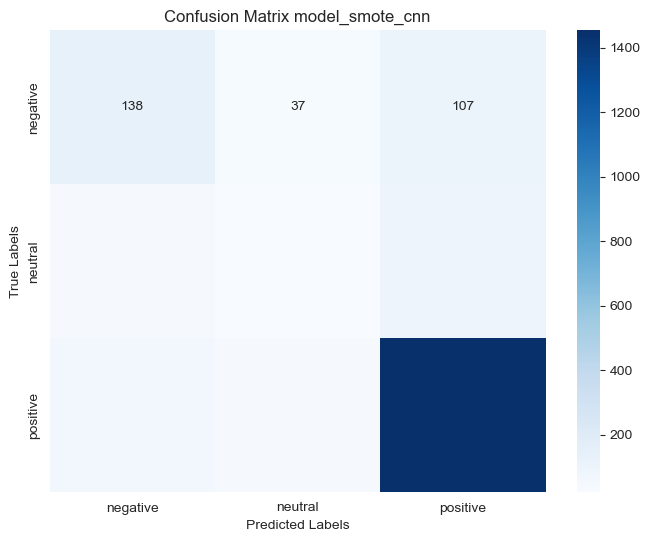

In [263]:
# Construct the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
labels = ['negative', 'neutral', 'positive']
fig34, ax34 = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax34)
ax34.set_xlabel('Predicted Labels')
ax34.set_ylabel('True Labels')
ax34.set_title('Confusion Matrix model_smote_cnn')
plt.show()

In [264]:
# Get predicted probabilities
y_pred_probs = model_smote_cnn.predict(X_test)

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate AUC score per class
auc_scores = []

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# Calculate micro-average AUC score
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Print AUC scores per class
for i, auc_score in enumerate(auc_scores):
    print(f"AUC for class {i}: {auc_score}")

# Print micro-average AUC score
print("Micro-average AUC Model_CNN_SMOTE:", roc_auc_micro)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC for class 0: 0.8820271798809436
AUC for class 1: 0.7679514989710217
AUC for class 2: 0.8704206350598401
Micro-average AUC Model_CNN_SMOTE: 0.9326994375000001


In [265]:
import os
#a function to save the images
def save_image(fig, filename):
    if not os.path.exists("Data Viz"):
        os.makedirs("Data Viz")
    images_path = os.path.join("Data Viz", filename)
    fig.savefig(images_path)
 
# Save the images to the images folder
# Save the images to the images folder
save_image(fig, "World cloud for different classes.png")
save_image(fig1, "Distribution of Sentiment.png")
save_image(fig2, "Confusion Matrix_Naive Bayes.png")
save_image(fig3, "ROC Curve for Multiclass Classification_Naive_Multinomial.png")
save_image(fig4, "'Confusion Matrix_Naive_Bayes with TFIDF.png")
save_image(fig5, "Micro-averaged ROC Curve for Naive_Bayes with TFIDF.png")
save_image(fig6, "Micro-averaged ROC Curve for Naive_Bayes with TFIDF_N-Gram.png")
save_image(fig8, "Confusion Matrix_Naive_Bayes with TFIDF.png")
save_image(fig9, "Confusion Matrix_Random Forest_SMOTE_Search.png")
save_image(fig10, "RNN-LSTM Model1 Graph.png")
save_image(fig11, "Confusion Matrix Model1.png")
save_image(fig12, "ROC Curve for Multi-class Classification_Model1.png")
save_image(fig13, 'Confusion Matrix RNN-LSTM Model2.png')
save_image(fig14, "ROC Curve for Multi-class Classification Model 2.png")
save_image(fig15, "Model3 Accuracy_loss graph.png")
save_image(fig16, "Confusion Matrix RNN-LSTM Model3.png")
save_image(fig17, "ROC Curve for Multi-class Classification Model 3.png")
save_image(fig18, "Model4 Accuracy_loss Graph.png")
save_image(fig19, "Confusion Matrix RNN-LSTM Model4.png")
save_image(fig21, "CNN_Model1 Accuracy_loss graph.png")
save_image(fig22, 'Confusion Matrix Model1_CNN')
save_image(fig23, "ROC Curve Model1_CNN.png")
save_image(fig24, "Model2_CNN.png")
save_image(fig25, "Confusion Matrix Model2_CNN.png")
save_image(fig26, "ROC Curve Model2_CNN.png")
save_image(fig27, "Model3_CNN Accuracy_loss.png")
save_image(fig28, "Confusion Matrix Model3_CNN.png")
save_image(fig29, "Model4_CNN Accuracy_loss graph.png")
save_image(fig30, 'Confusion Matrix Model4_CNN')
save_image(fig31, 'Modelfinetuned_CNN Accuracy_loss')
save_image(fig32, "Confusion Matrix model_finetuned.png")
save_image(fig33, "model_smote_cnn_acc_loss.png")
save_image(fig34, "Confusion Matrix model_smote_cnn.png")